# Music Recommender System
## (Data Scraping/Collection and Preprocessing)
In the realm of music streaming and digital entertainment, providing accurate and personalised song recommendations is essential for improving user engagement and satisfaction. A song recommender system combines content-based filtering, which analyses the attributes and features of songs, with collaborative filtering, which considers user preferences and behaviours, to deliver highly relevant music suggestions. By integrating these advanced recommendation techniques, the system aims to enhance users' music discovery journey, ensuring they find new songs and artists that align with their tastes. The development of such a model not only enriches the user experience but also supports the music industry's efforts in promoting diverse and emerging artists, fostering a more dynamic and engaging music ecosystem.

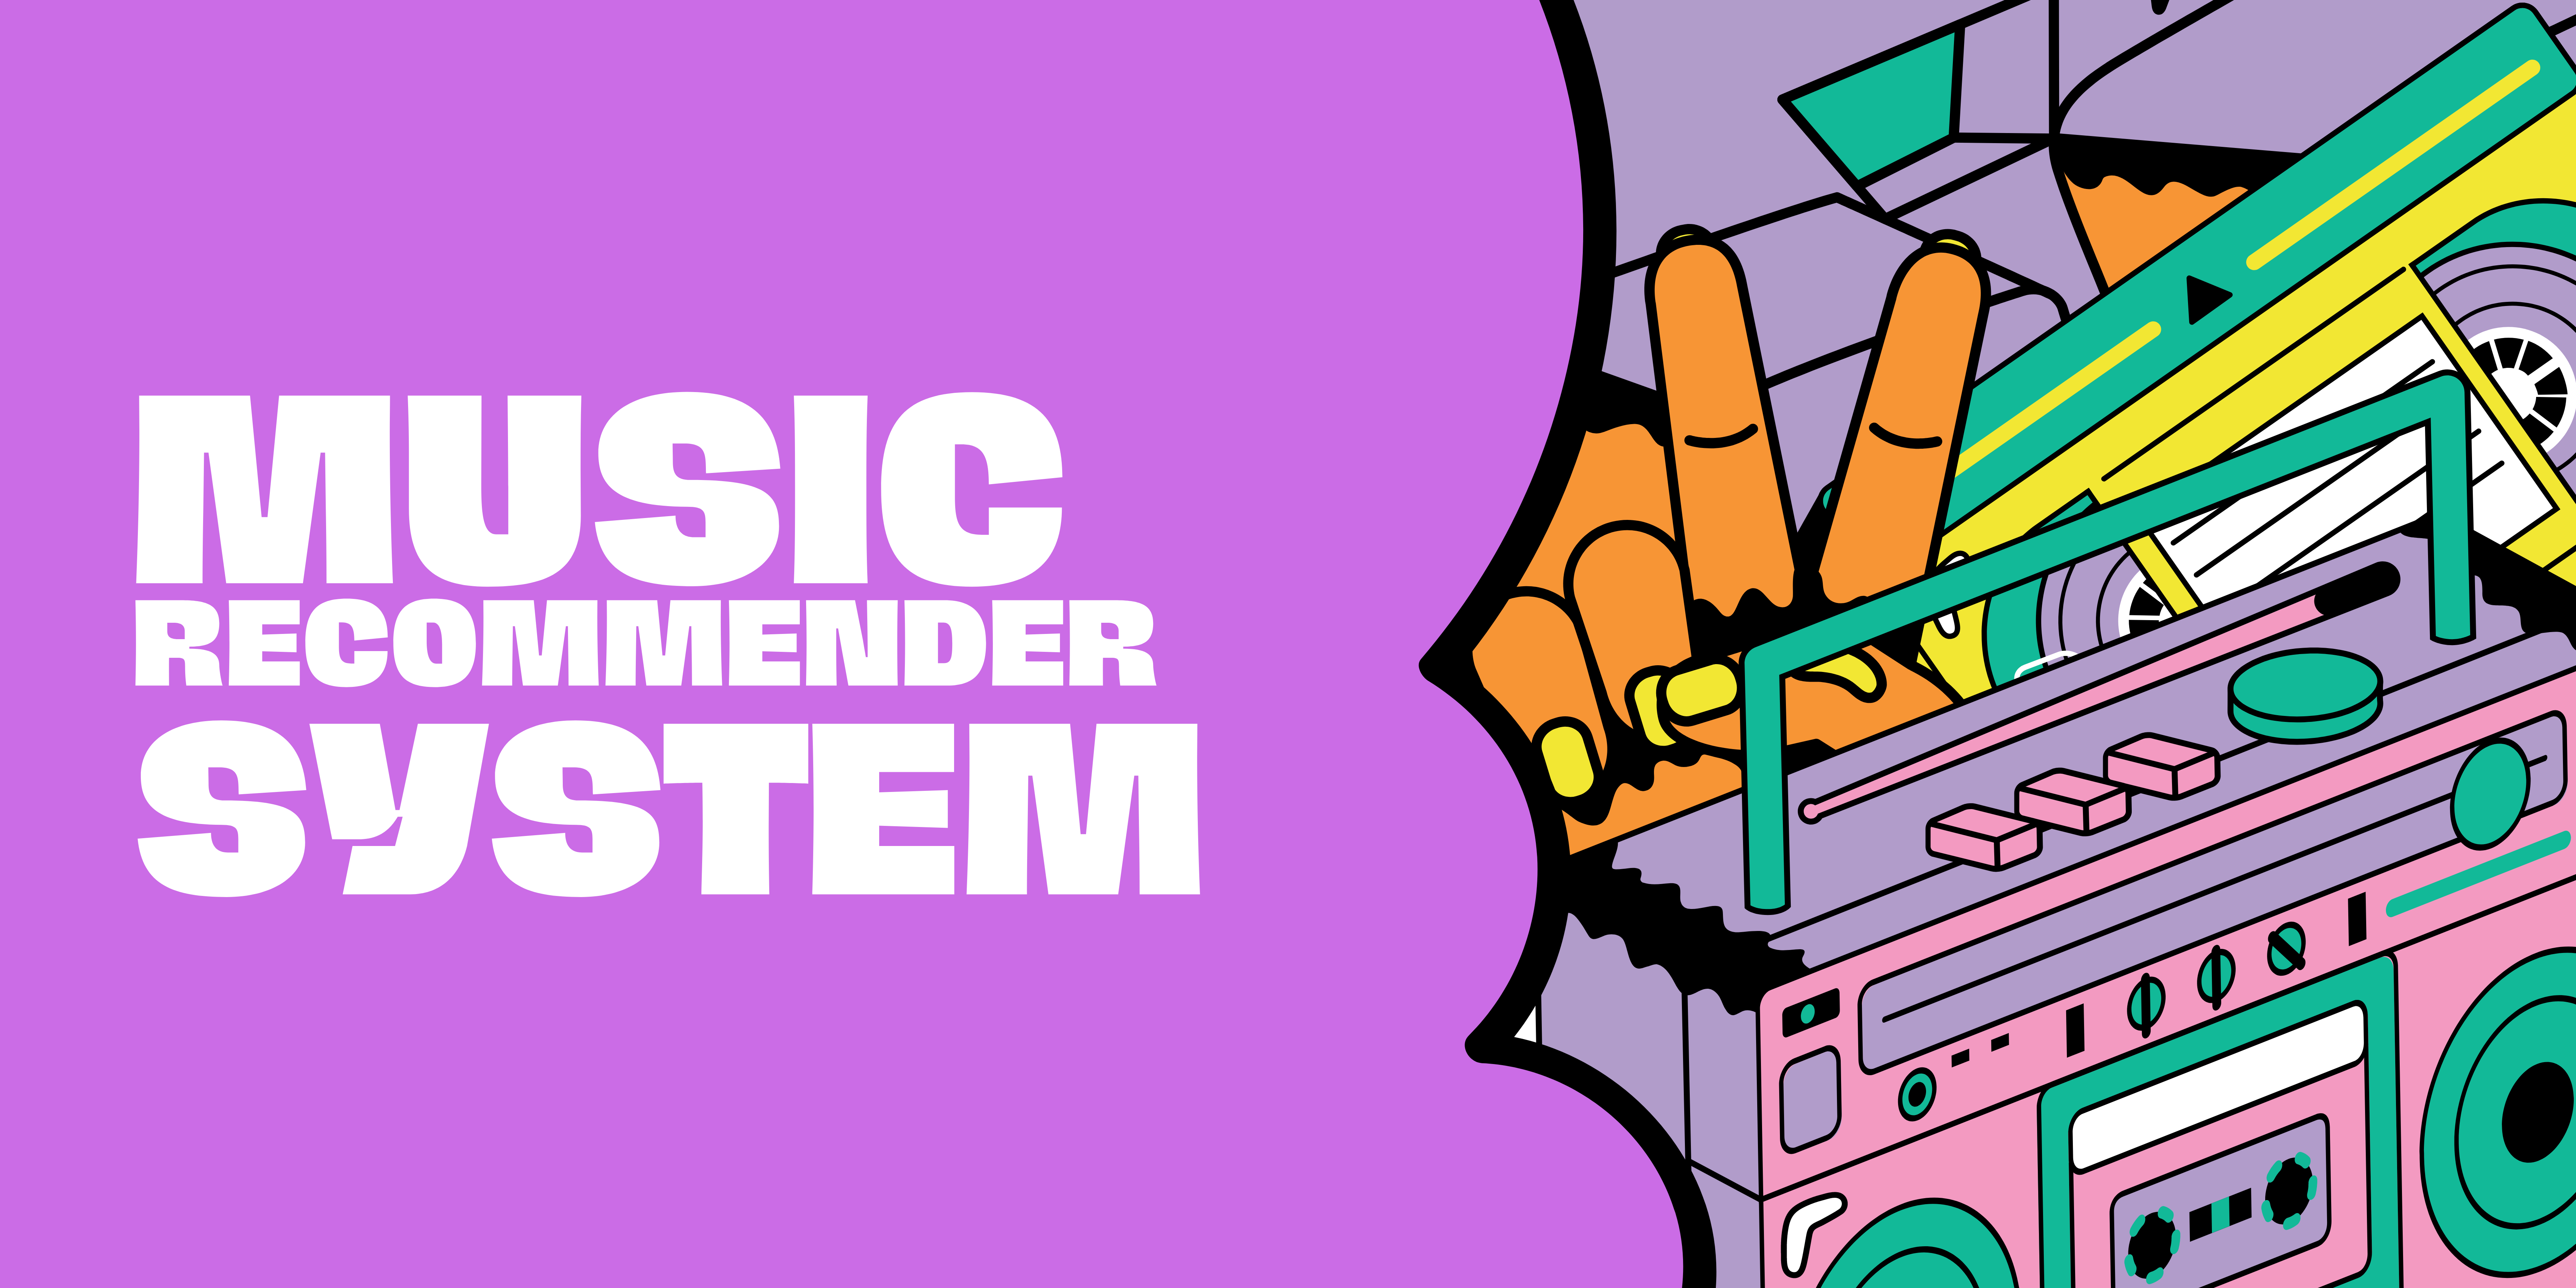

## Our Task: 
To scrape and preprocess features and convert them to embeddings which are able to help compare similiarity between songs and therefore, suggest personalised song recommendations to users, enhancing their music discovery experience.

## Our Approach:
We collected data from multiple sources, including the Spotify API, Genius API and Musixmatch API, to gather information about songs and artists. The data includes song names, artist names, genres, popularity, follower count and many more features related to music and song.

For data preprocessing, we tokenized and performed stemming and lemmatization of the text data, removed stop words, and handled special characters. 

We used the polyglot library to identify languages in multilingual song lyrics. 

We extracted numerical features such as popularity and follower count and normalized them using StandardScaler. 

Then for embedding we used Sentence Transform and Word2Vec.

## Neglected Approaches
We were also able to get the the song audio and generated their melspectrograms for audio analysis but later felt that features like tempo, instrumentalness, acousticness, etc which we got from the Spotify API represented the audio analysis quite well.

## Final Results:
Finally we have three columns: feature embeddings, artist embeddings and lyrics embeddings. We will use these to get a similiarity score and on that basis we will provide recommendations.

In [4]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Downloading and Importing Packages

In [5]:
!pip3 install spotipy bs4 polyglot pyicu pycld2 langdetect ytmusicapi sentence_transformers transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.4/262.4 kB 8.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 MB 39.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 43.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.1/252.1 kB 16.7 MB/s eta 0:00:00
  Created wheel for pyicu: filename=PyICU-2.13.1-cp310-cp310-linux_x86_64.whl size=484861 sha256=7afe9da23cdaac14108e4be7fdeb4b36a75c0f10edc0cdc298df44068d566d38
  Stored in directory: /root/.cache/pip/wheels/8e/45/08/f4bc505e31eb7bb779d493226921abf18cf55ed30142e70eae
  Created wheel for p

In [6]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from ast import literal_eval

from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel, XLMRobertaTokenizer, XLMRobertaModel
import torch

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import requests
import json
import csv
import requests
from bs4 import BeautifulSoup
import urllib.parse
from langdetect import detect_langs
import re
import time
from urllib.request import urlopen
from bs4 import BeautifulSoup
from time import sleep
from ytmusicapi import YTMusic

from polyglot.detect import Detector

import ast
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cityblock as manhattan_distance
from sklearn.preprocessing import PowerTransformer

2024-07-11 12:02:57.717224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 12:02:57.717350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 12:02:57.835837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Scraping Songs Metadata

In [316]:
with open('/kaggle/input/herework/config1518.json', 'r') as config_file:
    config = json.load(config_file)

In [317]:
# Spotify API credentials
SPOTIFY_CLIENT_ID = config['spotify']['client_id']
SPOTIFY_CLIENT_SECRET = config['spotify']['client_secret']

# Musixmatch API credentials
MUSIXMATCH_API_KEY = config['musixmatch']['api_key']

In [318]:
def get_song_details_from_spotify(spotify_id):
    sp = spotipy.Spotify(
        auth_manager=SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET))
    track = sp.track(spotify_id)
    audio_features = sp.audio_features(spotify_id)[0]
    artist_id = track['artists'][0]['id']
    artist = sp.artist(artist_id)
    if track and audio_features:
        song_details = {
            'name': track['name'],
            'artist': track['artists'][0]['name'],
            'album': track['album']['name'],
            'release_date': track['album']['release_date'],
            'popularity': track['popularity'],
            'duration_ms': track['duration_ms'],
            'explicit': track['explicit'],
            'genre': ', '.join(sp.artist(track['artists'][0]['id'])['genres']),
            'danceability': audio_features['danceability'],
            'energy': audio_features['energy'],
            'key': audio_features['key'],
            'loudness': audio_features['loudness'],
            'mode': audio_features['mode'],
            'speechiness': audio_features['speechiness'],
            'acousticness': audio_features['acousticness'],
            'instrumentalness': audio_features['instrumentalness'],
            'liveness': audio_features['liveness'],
            'valence': audio_features['valence'],
            'tempo': audio_features['tempo'],
            'time_signature': audio_features['time_signature'],
            'artist_popularity': artist['popularity'],
            'followers': artist['followers']['total']
            
        }
        return song_details
    else:
        return None
    
def get_lyrics(song, artist=None):
    base_url = 'https://www.tekstowo.pl/piosenka,'
    song = song.lower().replace(' ', '_')

    if artist:
        artist = artist.lower().replace(' ', '_')
        url = f"{base_url}{urllib.parse.quote(artist)},{urllib.parse.quote(song)}.html"
    else:
        url = f"{base_url}{urllib.parse.quote(song)}.html"

    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        soup = BeautifulSoup(response.content, 'html.parser')
        lyrics_div = soup.find('div', class_='inner-text')
        if lyrics_div:
            return lyrics_div.get_text(strip=True)
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {url}: {e}")
    return None

def get_lyrics_from_musixmatch(song_name, artist_name=None): # Gets only 30% lyrics on the free tier
    base_url = "https://api.musixmatch.com/ws/1.1/"
    method = "matcher.lyrics.get"
    params = {
        'q_track': song_name,
        'apikey': MUSIXMATCH_API_KEY,
        'format': 'json'
    }
    if artist_name:
        params['q_artist'] = artist_name
    response = requests.get(base_url + method, params=params)
    data = response.json()

    if data['message']['header']['status_code'] == 200 and 'lyrics' in data['message']['body']:
        lyrics = data['message']['body']['lyrics']['lyrics_body']
        return lyrics.split('*******')[0].strip()

    return None

ytmusic = YTMusic('/kaggle/input/oauth123/oauth.json')

def get_ytmusic_lyrics(song_name):
    # Search for the song
    try:
        search_results = ytmusic.search(song_name, filter='songs')
        if not search_results:
            return None

        # Get the first song's videoId
        song_video_id = search_results[0]['videoId']

        # Get the watch playlist to obtain the browseId
        watch_playlist = ytmusic.get_watch_playlist(song_video_id)
        browse_id = watch_playlist.get('lyrics')

        if not browse_id:
            return None

        # Get the lyrics
        lyrics = ytmusic.get_lyrics(browse_id)
        if 'lyrics' in lyrics:
            return lyrics['lyrics']
        else:
            return None
    except Exception as e:
        return None

def detect_language(lyrics):
    try:
        # First, try using polyglot
        detector = Detector(lyrics)
        detected_languages = [(lang.code, lang.confidence) for lang in detector.languages]
        langs = []
        for i in detected_languages:
            if i[0] != 'un':
                langs.append(i[0])
        return langs
    except:
        # If polyglot fails, use langdetect as a fallback
        try:
            detected_languages = detect_langs(lyrics)
            langs = [lang.lang for lang in detected_languages if lang.lang != 'un']
            return langs
        except:
            return []

In [319]:
global_counter = 0
def fetch_and_save_song_details(spotify_id, csv_file):
    global global_counter
    
    song_details = get_song_details_from_spotify(spotify_id)
    if song_details:
        lyrics = get_ytmusic_lyrics(song_details['name'],)
        if not lyrics :
            lyrics = get_lyrics(song_details['name'], song_details['artist'])
            if not lyrics : 
                lyrics = get_lyrics_from_musixmatch(song_details['name'], song_details['artist'])
        if lyrics:
            song_details['lyrics'] = lyrics
            song_details['language'] = detect_language(lyrics)
        else:
            song_details['lyrics'] = None
            song_details['language'] = None

        with open(csv_file, mode='a', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow([song_details['name'],
                             song_details['artist'],
                             song_details['album'],
                             song_details['release_date'],
                             song_details['popularity'],
                             song_details['duration_ms'],
                             song_details['explicit'],
                             song_details['genre'],
                             # song_details['audio_preview'],
                             song_details['danceability'],
                             song_details['energy'],
                             song_details['key'],
                             song_details['loudness'],
                             song_details['mode'],
                             song_details['speechiness'],
                             song_details['acousticness'],
                             song_details['instrumentalness'],
                             song_details['liveness'],
                             song_details['valence'],
                             song_details['tempo'],
                             song_details['time_signature'],
                             song_details['artist_popularity'],
                             song_details['followers'],
                             song_details['lyrics'],
                             song_details['language']])
            global_counter += 1
            print(f"Total: {global_counter}")
        return song_details
    else:
        return "Song not found"

In [ ]:
csv_file = 'dataset17379.csv'
with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Name', 'Artist', 'Album', 'Release Date', 'Popularity',
                     'Duration ms', 'Explicit', 'Genre',
                     'Danceability', 'Energy', 'Key', 'Loudness',
                     'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness',
                     'Liveness', 'Valence', 'Tempo', 'Time Signature','Artist Popularity',
                     'Artist Followers', 'Lyrics', 'Language'])
    
#removed track id and track url
csv_file = 'dataset17379.csv'

# Read song names from music.csv and fetch details
with open("/kaggle/input/songs-and-config/songs.json", mode='r', encoding='utf-8') as readin:
    song_ids = json.load(readin)

# As the credentials scraped data in intervals of 1k-1.6k songs, we had 
# to change the credentials quite some times so here is an example code for
# scraping from a given start line

start_line = 17379
csv_file = 'dataset17379.csv'
for index, spotify_id in enumerate(song_ids[start_line:], start=start_line):
    details = fetch_and_save_song_details(spotify_id, csv_file)
#     print(json.dumps(details, indent=2)) # Check json metadata

# Preprocessing Data

## Loading Data and NULL Name Removal

In [321]:
loaded_data = pd.read_csv('/kaggle/input/msrdata/concatenated_dataset.csv')
with open('/kaggle/input/msrdata/filtered_songdata.json', 'r') as f:
    artist_info = json.load(f)

In [322]:
loaded_data.isna().sum()

Name                   64
Artist                 64
Album                  39
Release Date            0
Popularity              0
Duration ms             0
Explicit                0
Genre                4668
Danceability            0
Energy                  0
Key                     0
Loudness                0
Mode                    0
Speechiness             0
Acousticness            0
Instrumentalness        0
Liveness                0
Valence                 0
Tempo                   0
Time Signature          0
Artist Popularity       0
Artist Followers        0
Lyrics               5479
Language             5479
dtype: int64

In [323]:
prep_data = loaded_data.dropna(subset=['Name']).reset_index(drop=True)
prep_data.isna().sum()

Name                    0
Artist                  0
Album                   0
Release Date            0
Popularity              0
Duration ms             0
Explicit                0
Genre                4604
Danceability            0
Energy                  0
Key                     0
Loudness                0
Mode                    0
Speechiness             0
Acousticness            0
Instrumentalness        0
Liveness                0
Valence                 0
Tempo                   0
Time Signature          0
Artist Popularity       0
Artist Followers        0
Lyrics               5415
Language             5415
dtype: int64

## Adding the artist genres to the main data

In [324]:
song_to_genre = {}
for item in artist_info:
    title = item['SongData']['title']
    genres = item['SongData']['artists'][0]['genre']
    song_to_genre[title] = genres

def genre_list_to_string(genres):
    return ', '.join(genres)

prep_data['artist_genre'] = prep_data['Name'].map(lambda x: genre_list_to_string(song_to_genre[x]) if x in song_to_genre else None)

prep_data

,Name,Artist,Album,Release Date,Popularity,Duration ms,Explicit,Genre,Danceability,Energy,...,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Artist Popularity,Artist Followers,Lyrics,Language,artist_genre
0,Taquei na Muda,Dj Créu,Taquei na Muda,2021-10-05,22,95555,False,"funk 150 bpm, rave funk",0.924,0.765,...,0.000000,0.2870,0.8870,135.135,4,27,3834,NaN,NaN,"funk 150 bpm, rave funk"
1,Cuatro Paredes,Grupo Legitimo,Pídeme,2017-02-27,47,185666,False,"musica mexicana, musica potosina, norteno, nor...",0.699,0.907,...,0.000000,0.1110,0.8560,111.966,4,55,453276,"Desde el primer momento en que te vi, me robas...",['es'],"corrido, musica mexicana, musica potosina, nor..."
2,Reich mir die Hand,Blutengel,Tränenherz,2011-02-18,0,205129,False,"dark wave, gothic metal, medieval rock, modern...",0.596,0.930,...,0.463000,0.1020,0.6470,126.020,4,45,179891,Einsam irrst du durch die kalte NachtAuf der S...,['de'],"gothic metal, medieval rock, modern goth, neue..."
3,Aftershock,Pentakill,III: Lost Chapter,2021-09-08,40,210506,False,melodic power metal,0.474,0.956,...,0.589000,0.0403,0.1550,140.100,4,50,333125,"Foolish Creatures,Impeding progress against th...",['en'],"bass house, tekk"
4,The Lonely Goatherd,Julie Andrews,The Sound of Music - Original Soundtrack Recor...,1965,0,190240,False,"hollywood, movie tunes, show tunes",0.667,0.255,...,0.000000,0.2300,0.6050,100.285,4,55,130226,[Maria:]High on a hill was a lonely goatherdLa...,['en'],"hollywood, movie tunes, show tunes"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24913,You got a friend in me,Morunas,Piano Evergreens,2020-01-27,32,106224,False,anime lo-fi,0.709,0.122,...,0.942000,0.1070,0.3700,99.991,4,46,4125,You've got a friend in me\r\nYou've got a frie...,['en'],anime lo-fi
24914,Bara Bara' Bere Bere',Los Latinos,Compilation Football World Brazilian (Summer 2...,2014-01-01,9,163186,False,NaN,0.687,0.948,...,0.000000,0.0309,0.8410,130.469,4,36,4083,"Bara bara bará,\nBere bere berê\nBara bara bar...",['pt'],
24915,All The Way Live (Spider-Man: Across the Spide...,Metro Boomin,METRO BOOMIN PRESENTS SPIDER-MAN: ACROSS THE S...,2023-06-02,64,245240,False,rap,0.775,0.555,...,0.003520,0.2080,0.2710,135.004,4,90,8537587,"Type of time you on (Metro)\r\nChanel cover, i...",['en'],"rap, trap"
24916,Christophe (feat. Maître Gims),Orelsan,La fête est finie,2017-10-20,47,166493,False,"french hip hop, old school rap francais, rap c...",0.822,0.735,...,0.000000,0.0757,0.6130,111.974,4,64,2387273,"Assalamu alaykum\r\nDéjà, t'as compris qu'j'm'...",['fr'],"french hip hop, old school rap francais, rap c..."


In [325]:
print(prep_data.columns)

Index(['Name', 'Artist', 'Album', 'Release Date', 'Popularity', 'Duration ms',
       'Explicit', 'Genre', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Time Signature', 'Artist Popularity',
       'Artist Followers', 'Lyrics', 'Language', 'artist_genre'],
      dtype='object')


## Extracting only the Release Year of the Songs

In [326]:
def extract_year(date_str):
    return pd.to_datetime(date_str, errors='coerce').year  # Coerce will return NaN for any unparsable date

prep_data['Release Date'] = prep_data['Release Date'].apply(extract_year)

prep_data['Release Date']

0        2021
1        2017
2        2011
3        2021
4        1965
         ... 
24913    2020
24914    2014
24915    2023
24916    2017
24917    2022
Name: Release Date, Length: 24918, dtype: int64

In [327]:
prep_data.describe()

,Release Date,Popularity,Duration ms,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Artist Popularity,Artist Followers
count,24918.000000,24918.000000,2.491800e+04,24918.000000,24918.000000,24918.000000,24918.000000,24918.000000,24918.000000,24918.000000,24918.000000,24918.000000,24918.000000,24918.000000,24918.000000,24918.000000,2.491800e+04
mean,2015.527370,39.856971,2.061834e+05,0.634414,0.645239,5.328196,-7.860455,0.553295,0.123172,0.277757,0.128806,0.196044,0.507858,122.900267,3.941769,52.150975,4.945114e+06
std,10.454539,23.849524,1.114467e+05,0.173378,0.219348,3.598158,4.598755,0.497162,0.123404,0.292201,0.287843,0.158881,0.252375,29.078675,0.384853,22.510597,1.459804e+07
min,1951.000000,0.000000,1.081000e+03,0.000000,0.000020,0.000000,-46.860000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2014.000000,22.000000,1.568645e+05,0.528000,0.508000,2.000000,-9.465000,0.000000,0.040900,0.029625,0.000000,0.097700,0.311000,99.986000,4.000000,39.000000,2.341450e+04
50%,2020.000000,43.000000,1.963480e+05,0.655000,0.671000,5.000000,-6.867500,1.000000,0.066300,0.161000,0.000009,0.129000,0.510000,123.406000,4.000000,55.000000,2.691990e+05
75%,2022.000000,58.000000,2.381328e+05,0.762000,0.818000,9.000000,-5.054000,1.000000,0.165000,0.464000,0.008650,0.255000,0.708000,140.577000,4.000000,69.000000,2.263789e+06
max,2024.000000,95.000000,4.142840e+06,0.988000,1.000000,11.000000,5.096000,1.000000,0.960000,0.996000,1.000000,0.994000,1.000000,236.138000,5.000000,100.000000,1.147607e+08


## Encoding Artists and Album Name

In [328]:
label_encoder = LabelEncoder()

prep_data['Artist'] = label_encoder.fit_transform(prep_data['Artist'])
prep_data['Album'] = label_encoder.fit_transform(prep_data['Album'])

print(prep_data.head())

                  Name  Artist  Album  Release Date  Popularity  Duration ms  \
0       Taquei na Muda    3072  15565          2021          22        95555   
1       Cuatro Paredes    4413  12862          2017          47       185666   
2   Reich mir die Hand    1499  16836          2011           0       205129   
3           Aftershock    8674   7714          2021          40       210506   
4  The Lonely Goatherd    5524  16309          1965           0       190240   

   Explicit                                              Genre  Danceability  \
0     False                            funk 150 bpm, rave funk         0.924   
1     False  musica mexicana, musica potosina, norteno, nor...         0.699   
2     False  dark wave, gothic metal, medieval rock, modern...         0.596   
3     False                                melodic power metal         0.474   
4     False                 hollywood, movie tunes, show tunes         0.667   

   Energy  ...  Instrumentalness  Live

# Visualisations

## Before Transformation Visualisation 

In [329]:
spot_features = [
#     'Release Date',
    'Popularity',
    'Duration ms',
#     'Explicit', # Either 0 or 1
    'Danceability',
    'Energy',
    'Key',
    'Loudness',
    'Mode', # Either 0 or 1
    'Acousticness',
    'Speechiness',
    'Instrumentalness', # Not visible on graph, extremely small
    'Valence',
    'Tempo',
    'Time Signature',
    'Artist Popularity',
    'Artist Followers'
]

In [330]:
initial_data = prep_data.copy()

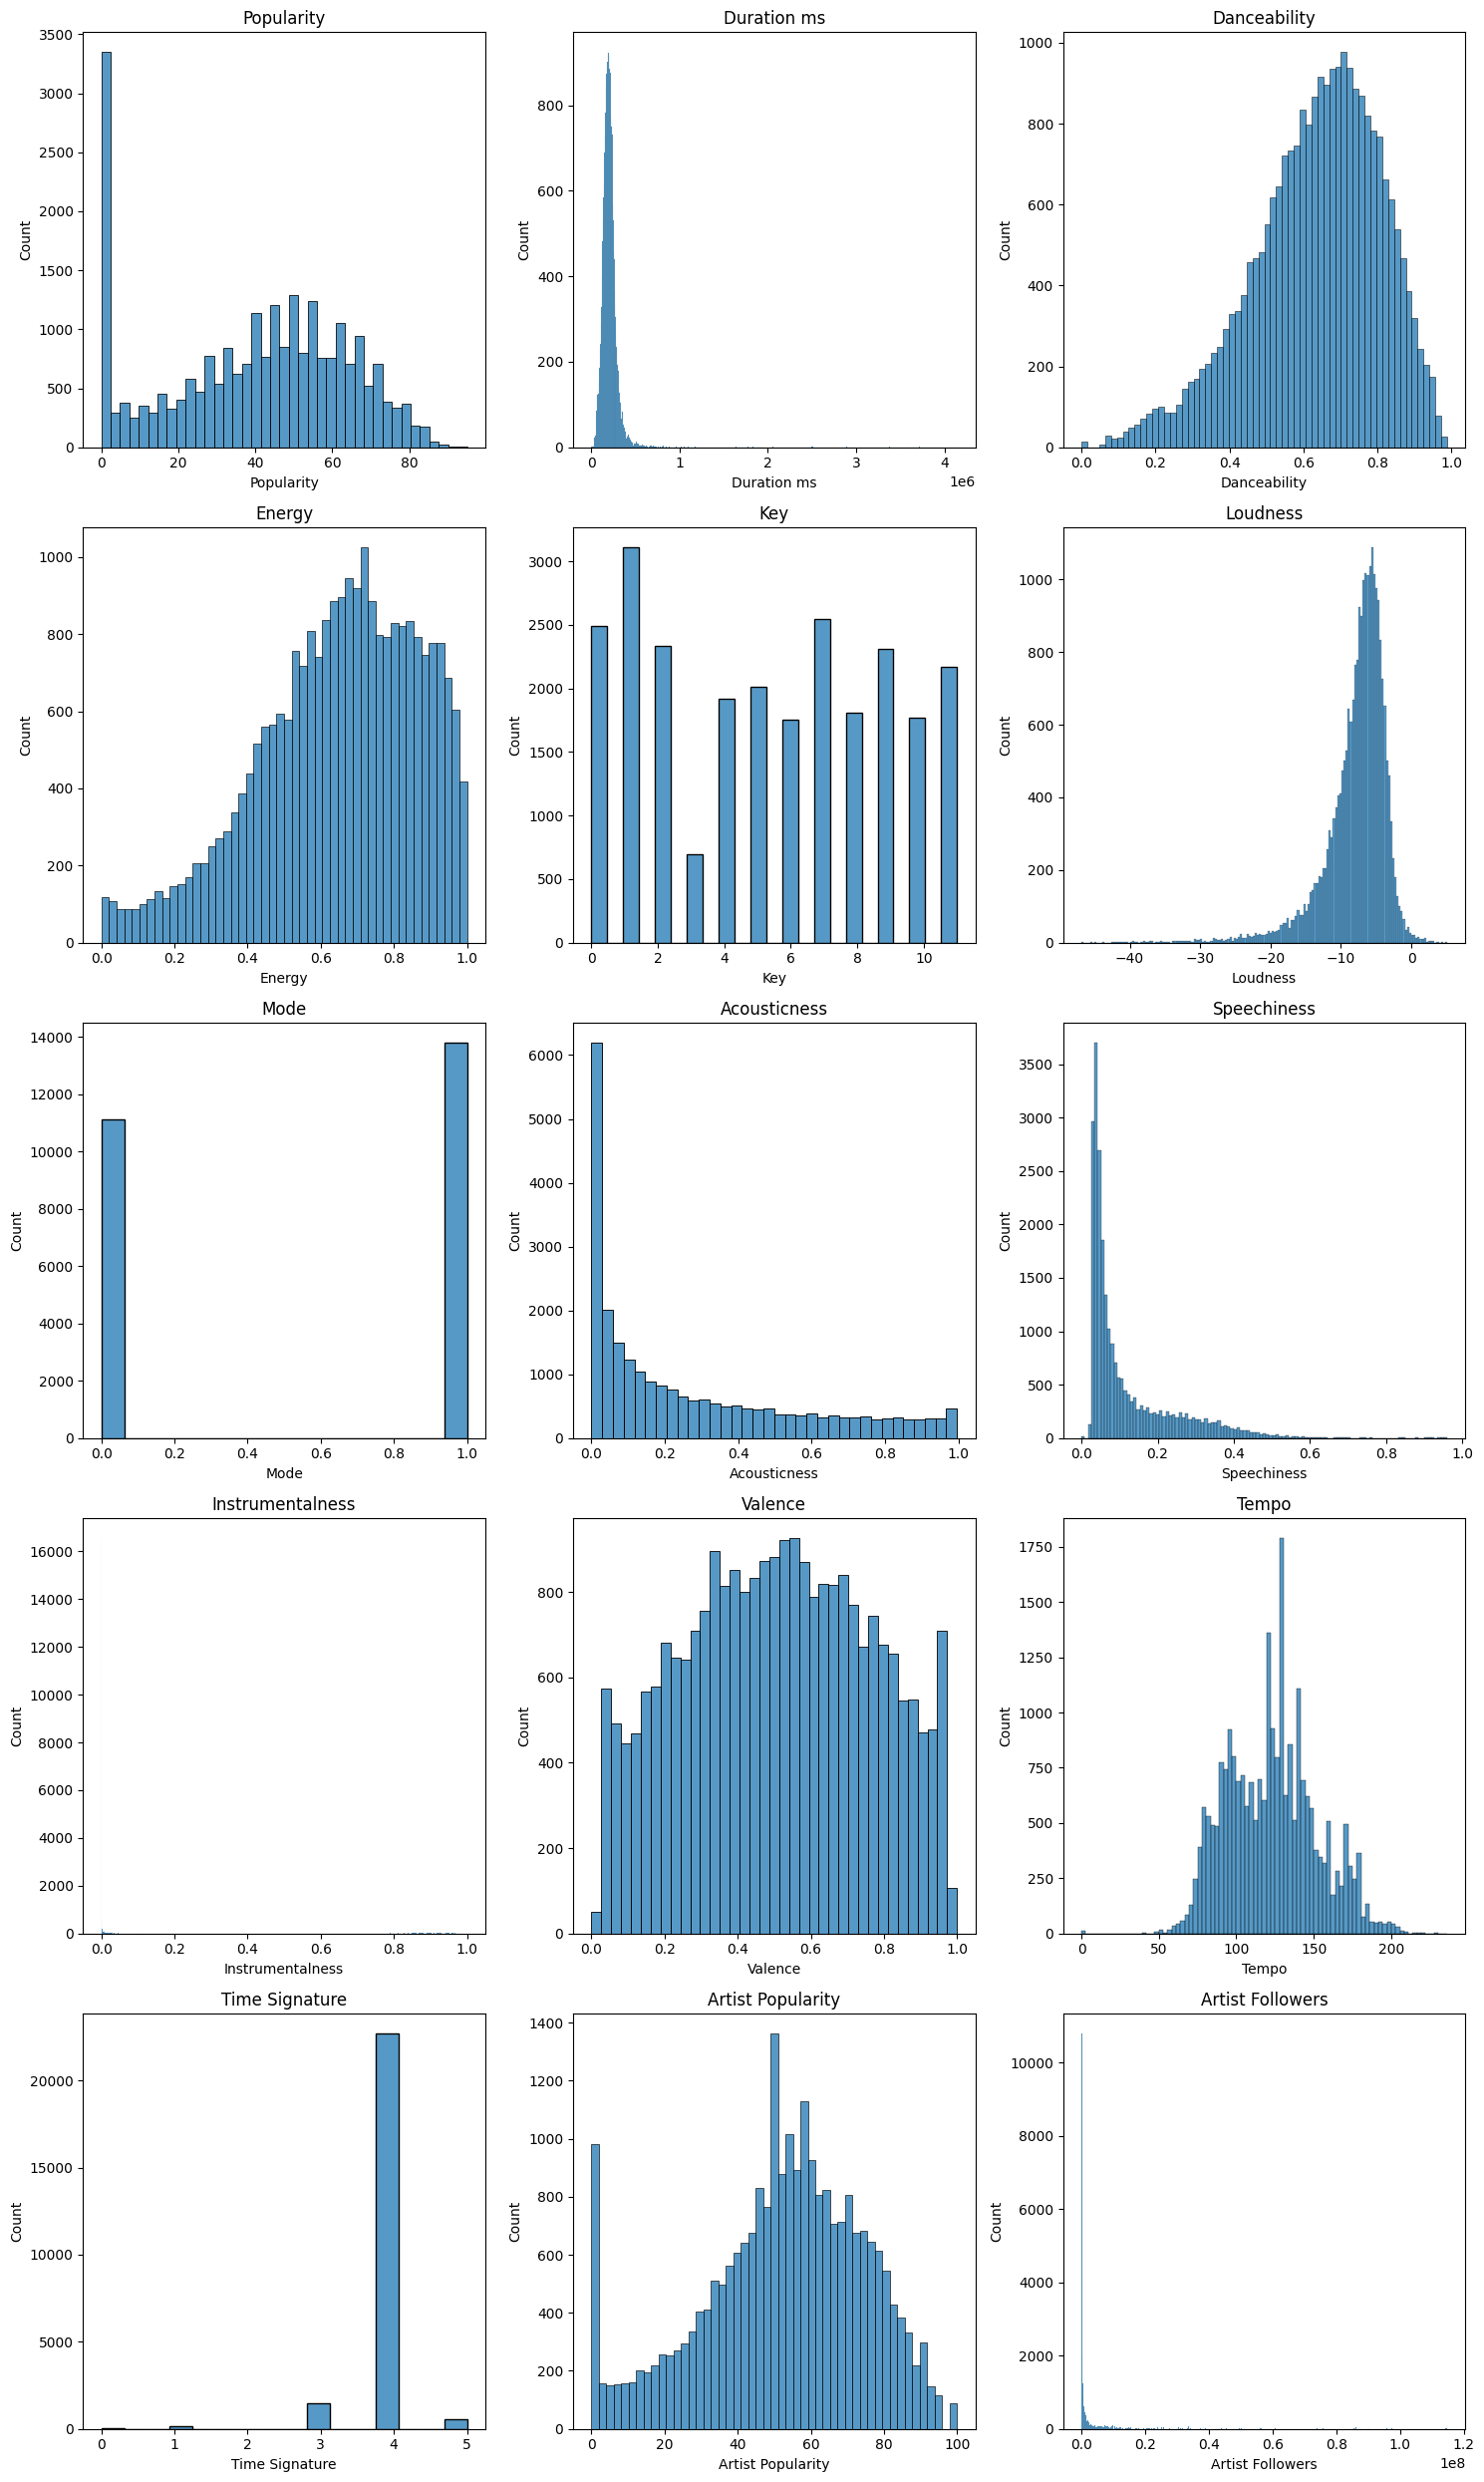

In [331]:
num_features = len(spot_features)
num_cols = 3 
num_rows = (num_features + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

axes = axes.flatten()

for i, att in enumerate(spot_features):
    sns.histplot(prep_data[att].dropna(), ax=axes[i])
    axes[i].set_title(att)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Applying Yeo-Johnson Transformation

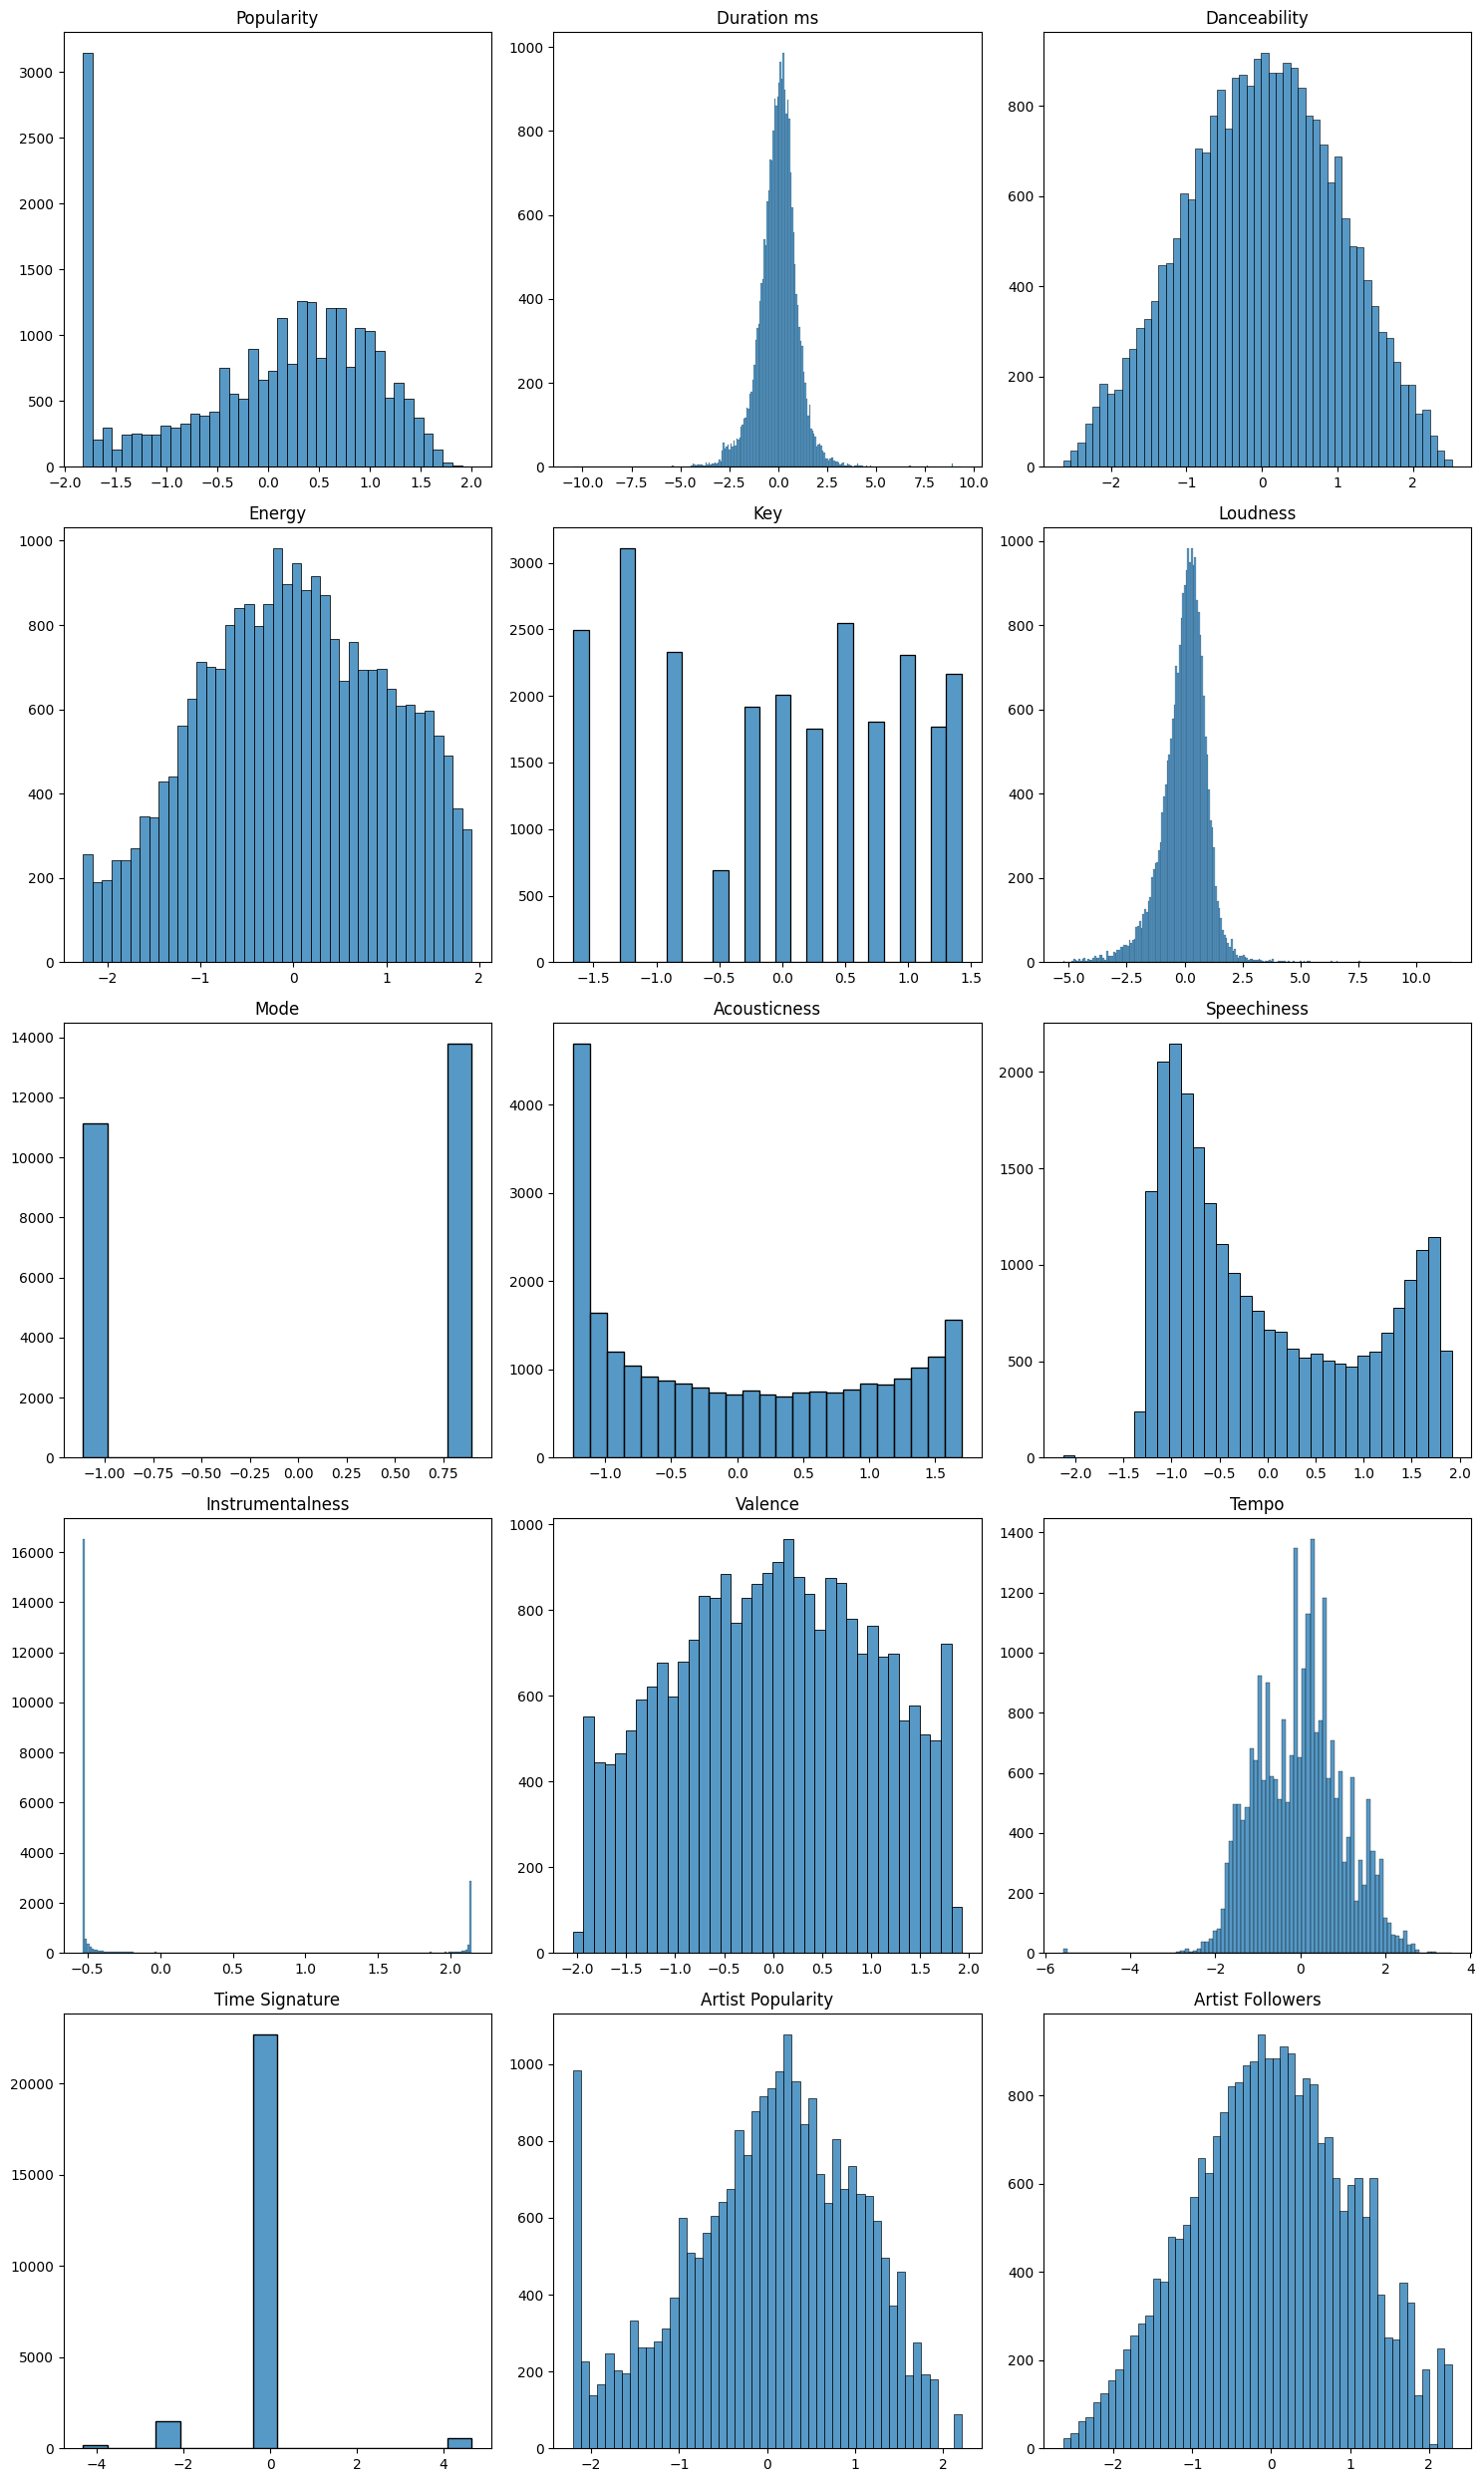

In [332]:
y_j = PowerTransformer(method='yeo-johnson').fit(prep_data[spot_features])

transformed_data = y_j.transform(prep_data[spot_features])
prep_data[spot_features] = transformed_data

num_features = len(spot_features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

axes = axes.flatten()

for i, feature in enumerate(spot_features):
    sns.histplot(transformed_data[:, i], kde=False, ax=axes[i])
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## MinMax Scale the numeric columns

In [333]:
scaler = MinMaxScaler()
columns_to_normalize = ['Artist', 'Album', 'Release Date','Popularity','Duration ms', 'Danceability', 'Energy', 
                        'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 
                        'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 
                        'Time Signature', 'Artist Popularity', 'Artist Followers']

normalized_features = scaler.fit_transform(initial_data[columns_to_normalize])
normalized_df = pd.DataFrame(normalized_features, columns=columns_to_normalize)
initial_data[columns_to_normalize] = normalized_df

In [334]:
prep_data

,Name,Artist,Album,Release Date,Popularity,Duration ms,Explicit,Genre,Danceability,Energy,...,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Artist Popularity,Artist Followers,Lyrics,Language,artist_genre
0,Taquei na Muda,3072,15565,2021,-0.645406,-1.759626,False,"funk 150 bpm, rave funk",1.964038,0.491662,...,-0.530753,0.2870,1.490528,0.445549,0.076504,-1.135146,-1.145486,NaN,NaN,"funk 150 bpm, rave funk"
1,Cuatro Paredes,4413,12862,2017,0.356348,-0.093305,False,"musica mexicana, musica potosina, norteno, nor...",0.295536,1.317426,...,-0.530753,0.1110,1.370730,-0.347451,0.076504,0.106120,0.163484,"Desde el primer momento en que te vi, me robas...",['es'],"corrido, musica mexicana, musica potosina, nor..."
2,Reich mir die Hand,1499,16836,2011,-1.823402,0.166633,False,"dark wave, gothic metal, medieval rock, modern...",-0.334907,1.461827,...,2.078239,0.1020,0.557128,0.138213,0.076504,-0.345570,-0.122722,Einsam irrst du durch die kalte NachtAuf der S...,['de'],"gothic metal, medieval rock, modern goth, neue..."
3,Aftershock,8674,7714,2021,0.090827,0.234534,False,melodic power metal,-0.982737,1.628729,...,2.116683,0.0403,-1.406573,0.610649,0.076504,-0.120713,0.066182,"Foolish Creatures,Impeding progress against th...",['en'],"bass house, tekk"
4,The Lonely Goatherd,5524,16309,1965,-1.823402,-0.030089,False,"hollywood, movie tunes, show tunes",0.091148,-1.627210,...,-0.530753,0.2300,0.392305,-0.763438,0.076504,0.106120,-0.218784,[Maria:]High on a hill was a lonely goatherdLa...,['en'],"hollywood, movie tunes, show tunes"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24913,You got a friend in me,7718,12349,2020,-0.225193,-1.501579,False,anime lo-fi,0.361019,-1.988608,...,2.143929,0.1070,-0.539049,-0.774067,0.076504,-0.300766,-1.128341,You've got a friend in me\r\nYou've got a frie...,['en'],anime lo-fi
24914,Bara Bara' Bere Bere',6596,3647,2014,-1.262198,-0.425931,False,NaN,0.217974,1.576958,...,-0.530753,0.0309,1.312684,0.288929,0.076504,-0.744679,-1.130744,"Bara bara bará,\nBere bere berê\nBara bara bar...",['pt'],
24915,All The Way Live (Spider-Man: Across the Spide...,7446,9727,2023,0.968858,0.638965,False,rap,0.812867,-0.532628,...,-0.442195,0.2080,-0.936510,0.441172,0.076504,1.738326,1.195852,"Type of time you on (Metro)\r\nChanel cover, i...",['en'],"rap, trap"
24916,Christophe (feat. Maître Gims),8389,9000,2017,0.356348,-0.374509,False,"french hip hop, old school rap francais, rap c...",1.155956,0.331306,...,-0.530753,0.0757,0.423736,-0.347170,0.076504,0.518902,0.723400,"Assalamu alaykum\r\nDéjà, t'as compris qu'j'm'...",['fr'],"french hip hop, old school rap francais, rap c..."


## Correlation Matrix

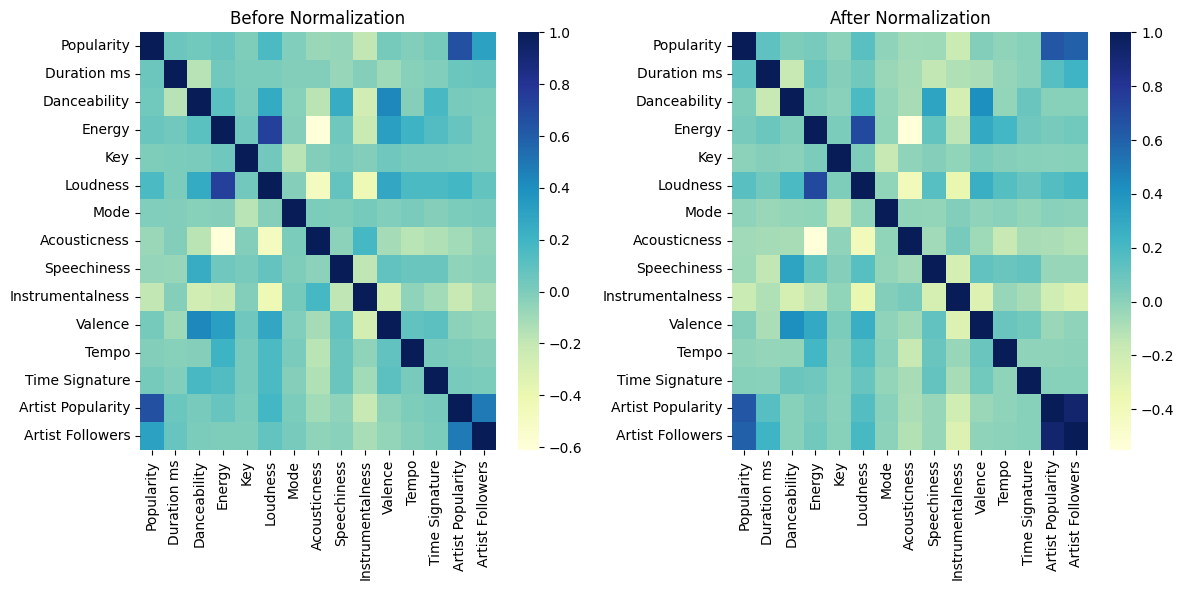

In [335]:
corr_before = initial_data[spot_features].corr()

corr_after = prep_data[spot_features].corr()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(corr_before, cmap='YlGnBu', ax=axes[0])
axes[0].set_title('Before Normalization')

sns.heatmap(corr_after, cmap='YlGnBu', ax=axes[1])
axes[1].set_title('After Normalization')

plt.tight_layout()
plt.show()

## One Hot Encoding the Languages

In [336]:
mlb = MultiLabelBinarizer()
prep_data = initial_data

def safe_literal_eval(val):
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError):
        return ['un']
    
prep_data['Language'] = prep_data['Language'].apply(safe_literal_eval)
language_encoded = mlb.fit_transform(prep_data['Language'])

# Convert the encoded arrays to lists
ohe_languages = [list(row) for row in language_encoded]

prep_data['ohe_languages'] = ohe_languages

prep_data

,Name,Artist,Album,Release Date,Popularity,Duration ms,Explicit,Genre,Danceability,Energy,...,Liveness,Valence,Tempo,Time Signature,Artist Popularity,Artist Followers,Lyrics,Language,artist_genre,ohe_languages
0,Taquei na Muda,0.231221,0.771652,0.958904,0.231579,0.022810,False,"funk 150 bpm, rave funk",0.935223,0.764995,...,0.288732,0.8870,0.572271,0.8,0.27,0.000033,NaN,[un],"funk 150 bpm, rave funk","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Cuatro Paredes,0.332154,0.637648,0.904110,0.494737,0.044567,False,"musica mexicana, musica potosina, norteno, nor...",0.707490,0.906998,...,0.111670,0.8560,0.474155,0.8,0.55,0.003950,"Desde el primer momento en que te vi, me robas...",[es],"corrido, musica mexicana, musica potosina, nor...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Reich mir die Hand,0.112826,0.834664,0.821918,0.000000,0.049266,False,"dark wave, gothic metal, medieval rock, modern...",0.603239,0.929999,...,0.102616,0.6470,0.533671,0.8,0.45,0.001568,Einsam irrst du durch die kalte NachtAuf der S...,[de],"gothic metal, medieval rock, modern goth, neue...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Aftershock,0.652868,0.382430,0.958904,0.421053,0.050564,False,melodic power metal,0.479757,0.955999,...,0.040543,0.1550,0.593297,0.8,0.50,0.002903,"Foolish Creatures,Impeding progress against th...",[en],"bass house, tekk","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,The Lonely Goatherd,0.415776,0.808537,0.191781,0.000000,0.045671,False,"hollywood, movie tunes, show tunes",0.675101,0.254985,...,0.231388,0.6050,0.424688,0.8,0.55,0.001135,[Maria:]High on a hill was a lonely goatherdLa...,[en],"hollywood, movie tunes, show tunes","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24913,You got a friend in me,0.580912,0.612216,0.945205,0.336842,0.025386,False,anime lo-fi,0.717611,0.121983,...,0.107646,0.3700,0.423443,0.8,0.46,0.000036,You've got a friend in me\r\nYou've got a frie...,[en],anime lo-fi,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
24914,Bara Bara' Bere Bere',0.496462,0.180804,0.863014,0.094737,0.039139,False,NaN,0.695344,0.947999,...,0.031087,0.8410,0.552512,0.8,0.36,0.000036,"Bara bara bará,\nBere bere berê\nBara bara bar...",[pt],,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
24915,All The Way Live (Spider-Man: Across the Spide...,0.560440,0.482227,0.986301,0.673684,0.058951,False,rap,0.784413,0.554991,...,0.209256,0.2710,0.571717,0.8,0.90,0.074395,"Type of time you on (Metro)\r\nChanel cover, i...",[en],"rap, trap","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
24916,Christophe (feat. Maître Gims),0.631417,0.446185,0.904110,0.494737,0.039938,False,"french hip hop, old school rap francais, rap c...",0.831984,0.734995,...,0.076157,0.6130,0.474189,0.8,0.64,0.020802,"Assalamu alaykum\r\nDéjà, t'as compris qu'j'm'...",[fr],"french hip hop, old school rap francais, rap c...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [337]:
prep_data

,Name,Artist,Album,Release Date,Popularity,Duration ms,Explicit,Genre,Danceability,Energy,...,Liveness,Valence,Tempo,Time Signature,Artist Popularity,Artist Followers,Lyrics,Language,artist_genre,ohe_languages
0,Taquei na Muda,0.231221,0.771652,0.958904,0.231579,0.022810,False,"funk 150 bpm, rave funk",0.935223,0.764995,...,0.288732,0.8870,0.572271,0.8,0.27,0.000033,NaN,[un],"funk 150 bpm, rave funk","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Cuatro Paredes,0.332154,0.637648,0.904110,0.494737,0.044567,False,"musica mexicana, musica potosina, norteno, nor...",0.707490,0.906998,...,0.111670,0.8560,0.474155,0.8,0.55,0.003950,"Desde el primer momento en que te vi, me robas...",[es],"corrido, musica mexicana, musica potosina, nor...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Reich mir die Hand,0.112826,0.834664,0.821918,0.000000,0.049266,False,"dark wave, gothic metal, medieval rock, modern...",0.603239,0.929999,...,0.102616,0.6470,0.533671,0.8,0.45,0.001568,Einsam irrst du durch die kalte NachtAuf der S...,[de],"gothic metal, medieval rock, modern goth, neue...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Aftershock,0.652868,0.382430,0.958904,0.421053,0.050564,False,melodic power metal,0.479757,0.955999,...,0.040543,0.1550,0.593297,0.8,0.50,0.002903,"Foolish Creatures,Impeding progress against th...",[en],"bass house, tekk","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,The Lonely Goatherd,0.415776,0.808537,0.191781,0.000000,0.045671,False,"hollywood, movie tunes, show tunes",0.675101,0.254985,...,0.231388,0.6050,0.424688,0.8,0.55,0.001135,[Maria:]High on a hill was a lonely goatherdLa...,[en],"hollywood, movie tunes, show tunes","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24913,You got a friend in me,0.580912,0.612216,0.945205,0.336842,0.025386,False,anime lo-fi,0.717611,0.121983,...,0.107646,0.3700,0.423443,0.8,0.46,0.000036,You've got a friend in me\r\nYou've got a frie...,[en],anime lo-fi,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
24914,Bara Bara' Bere Bere',0.496462,0.180804,0.863014,0.094737,0.039139,False,NaN,0.695344,0.947999,...,0.031087,0.8410,0.552512,0.8,0.36,0.000036,"Bara bara bará,\nBere bere berê\nBara bara bar...",[pt],,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
24915,All The Way Live (Spider-Man: Across the Spide...,0.560440,0.482227,0.986301,0.673684,0.058951,False,rap,0.784413,0.554991,...,0.209256,0.2710,0.571717,0.8,0.90,0.074395,"Type of time you on (Metro)\r\nChanel cover, i...",[en],"rap, trap","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
24916,Christophe (feat. Maître Gims),0.631417,0.446185,0.904110,0.494737,0.039938,False,"french hip hop, old school rap francais, rap c...",0.831984,0.734995,...,0.076157,0.6130,0.474189,0.8,0.64,0.020802,"Assalamu alaykum\r\nDéjà, t'as compris qu'j'm'...",[fr],"french hip hop, old school rap francais, rap c...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [338]:
prep_data.drop(columns=['Language'], inplace=True)

In [339]:
prep_data.to_csv('processed_dataset.csv', index=False)

# Embeddings Generation

In [340]:
df = pd.read_csv('/kaggle/working/processed_dataset.csv')

In [341]:
df['Genre'].fillna('', inplace=True)
df['Lyrics'].fillna('', inplace=True)
df['artist_genre'].fillna('', inplace=True)

In [342]:
# xml_roberta is trained on multiple languages, so it can be used for the Lyrics column
xlm_roberta_tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
xlm_roberta_model = XLMRobertaModel.from_pretrained('xlm-roberta-base').to(device)

# Genres are in English, so we can use bert for genre column
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

In [343]:
def get_average_transformer_embedding(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy().flatten()

In [344]:
df['Lyrics_Embedding'] = df['Lyrics'].apply(lambda x: get_average_transformer_embedding(x, xlm_roberta_tokenizer, xlm_roberta_model))
print("Lyrics Embeddings Added")
df['Artist_Genre_Embedding'] = df['artist_genre'].apply(lambda x: get_average_transformer_embedding(x, bert_tokenizer, bert_model))
print("Artist Genre Embeddings Added")

Lyrics Embeddings Added
Artist Genre Embeddings Added


In [345]:
df

,Name,Artist,Album,Release Date,Popularity,Duration ms,Explicit,Genre,Danceability,Energy,...,Valence,Tempo,Time Signature,Artist Popularity,Artist Followers,Lyrics,artist_genre,ohe_languages,Lyrics_Embedding,Artist_Genre_Embedding
0,Taquei na Muda,0.231221,0.771652,0.958904,0.231579,0.022810,False,"funk 150 bpm, rave funk",0.935223,0.764995,...,0.8870,0.572271,0.8,0.27,0.000033,,"funk 150 bpm, rave funk","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.07224147, 0.099085316, 0.027978677, -0.0209...","[0.4133677, -0.027804162, 0.36961997, -0.05730..."
1,Cuatro Paredes,0.332154,0.637648,0.904110,0.494737,0.044567,False,"musica mexicana, musica potosina, norteno, nor...",0.707490,0.906998,...,0.8560,0.474155,0.8,0.55,0.003950,"Desde el primer momento en que te vi, me robas...","corrido, musica mexicana, musica potosina, nor...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.0038712362, 0.005807838, -0.014279121, 0.0...","[-0.075081, 0.025541715, 0.16632468, 0.0184441..."
2,Reich mir die Hand,0.112826,0.834664,0.821918,0.000000,0.049266,False,"dark wave, gothic metal, medieval rock, modern...",0.603239,0.929999,...,0.6470,0.533671,0.8,0.45,0.001568,Einsam irrst du durch die kalte NachtAuf der S...,"gothic metal, medieval rock, modern goth, neue...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.024085067, 0.01642362, 0.0052486965, 0.0108...","[0.12978935, 0.21471144, -0.14516503, -0.36153..."
3,Aftershock,0.652868,0.382430,0.958904,0.421053,0.050564,False,melodic power metal,0.479757,0.955999,...,0.1550,0.593297,0.8,0.50,0.002903,"Foolish Creatures,Impeding progress against th...","bass house, tekk","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.010277511, 0.00047562196, -0.0013192428, 0....","[0.24448287, -0.09709273, 0.124306716, -0.0751..."
4,The Lonely Goatherd,0.415776,0.808537,0.191781,0.000000,0.045671,False,"hollywood, movie tunes, show tunes",0.675101,0.254985,...,0.6050,0.424688,0.8,0.55,0.001135,[Maria:]High on a hill was a lonely goatherdLa...,"hollywood, movie tunes, show tunes","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.05373074, 0.026165834, -0.03811238, -0.0500...","[0.33459157, 0.062415905, 0.46037927, 0.246523..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24913,You got a friend in me,0.580912,0.612216,0.945205,0.336842,0.025386,False,anime lo-fi,0.717611,0.121983,...,0.3700,0.423443,0.8,0.46,0.000036,You've got a friend in me\r\nYou've got a frie...,anime lo-fi,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0138204275, 0.03170477, 0.003365677, 0.0126...","[0.38772887, -0.3142426, 0.04612658, -0.248838..."
24914,Bara Bara' Bere Bere',0.496462,0.180804,0.863014,0.094737,0.039139,False,,0.695344,0.947999,...,0.8410,0.552512,0.8,0.36,0.000036,"Bara bara bará,\nBere bere berê\nBara bara bar...",,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.0013204127, 0.028582878, 0.0056374855, -0....","[-0.009229004, -0.22186162, -0.3448265, 0.0165..."
24915,All The Way Live (Spider-Man: Across the Spide...,0.560440,0.482227,0.986301,0.673684,0.058951,False,rap,0.784413,0.554991,...,0.2710,0.571717,0.8,0.90,0.074395,"Type of time you on (Metro)\r\nChanel cover, i...","rap, trap","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.018787421, -0.00068230665, -0.019655287, -0...","[0.5009956, 0.12948047, 0.7053265, 0.10673113,..."
24916,Christophe (feat. Maître Gims),0.631417,0.446185,0.904110,0.494737,0.039938,False,"french hip hop, old school rap francais, rap c...",0.831984,0.734995,...,0.6130,0.474189,0.8,0.64,0.020802,"Assalamu alaykum\r\nDéjà, t'as compris qu'j'm'...","french hip hop, old school rap francais, rap c...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0017778369, 0.019963678, 0.008338648, -0.03...","[0.049884755, 0.09279294, 0.035557088, -0.2520..."


In [346]:
df_new = df.drop(['Lyrics', 'artist_genre', 'Genre'], axis = 1)
df_new

,Name,Artist,Album,Release Date,Popularity,Duration ms,Explicit,Danceability,Energy,Key,...,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Artist Popularity,Artist Followers,ohe_languages,Lyrics_Embedding,Artist_Genre_Embedding
0,Taquei na Muda,0.231221,0.771652,0.958904,0.231579,0.022810,False,0.935223,0.764995,1.000000,...,0.000000,0.288732,0.8870,0.572271,0.8,0.27,0.000033,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.07224147, 0.099085316, 0.027978677, -0.0209...","[0.4133677, -0.027804162, 0.36961997, -0.05730..."
1,Cuatro Paredes,0.332154,0.637648,0.904110,0.494737,0.044567,False,0.707490,0.906998,0.727273,...,0.000000,0.111670,0.8560,0.474155,0.8,0.55,0.003950,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.0038712362, 0.005807838, -0.014279121, 0.0...","[-0.075081, 0.025541715, 0.16632468, 0.0184441..."
2,Reich mir die Hand,0.112826,0.834664,0.821918,0.000000,0.049266,False,0.603239,0.929999,0.545455,...,0.463000,0.102616,0.6470,0.533671,0.8,0.45,0.001568,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.024085067, 0.01642362, 0.0052486965, 0.0108...","[0.12978935, 0.21471144, -0.14516503, -0.36153..."
3,Aftershock,0.652868,0.382430,0.958904,0.421053,0.050564,False,0.479757,0.955999,0.363636,...,0.589000,0.040543,0.1550,0.593297,0.8,0.50,0.002903,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.010277511, 0.00047562196, -0.0013192428, 0....","[0.24448287, -0.09709273, 0.124306716, -0.0751..."
4,The Lonely Goatherd,0.415776,0.808537,0.191781,0.000000,0.045671,False,0.675101,0.254985,0.000000,...,0.000000,0.231388,0.6050,0.424688,0.8,0.55,0.001135,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.05373074, 0.026165834, -0.03811238, -0.0500...","[0.33459157, 0.062415905, 0.46037927, 0.246523..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24913,You got a friend in me,0.580912,0.612216,0.945205,0.336842,0.025386,False,0.717611,0.121983,0.272727,...,0.942000,0.107646,0.3700,0.423443,0.8,0.46,0.000036,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0138204275, 0.03170477, 0.003365677, 0.0126...","[0.38772887, -0.3142426, 0.04612658, -0.248838..."
24914,Bara Bara' Bere Bere',0.496462,0.180804,0.863014,0.094737,0.039139,False,0.695344,0.947999,0.181818,...,0.000000,0.031087,0.8410,0.552512,0.8,0.36,0.000036,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.0013204127, 0.028582878, 0.0056374855, -0....","[-0.009229004, -0.22186162, -0.3448265, 0.0165..."
24915,All The Way Live (Spider-Man: Across the Spide...,0.560440,0.482227,0.986301,0.673684,0.058951,False,0.784413,0.554991,0.818182,...,0.003520,0.209256,0.2710,0.571717,0.8,0.90,0.074395,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.018787421, -0.00068230665, -0.019655287, -0...","[0.5009956, 0.12948047, 0.7053265, 0.10673113,..."
24916,Christophe (feat. Maître Gims),0.631417,0.446185,0.904110,0.494737,0.039938,False,0.831984,0.734995,0.090909,...,0.000000,0.076157,0.6130,0.474189,0.8,0.64,0.020802,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0017778369, 0.019963678, 0.008338648, -0.03...","[0.049884755, 0.09279294, 0.035557088, -0.2520..."


In [347]:
df_new.to_csv("LyricsAndGenreEmbeddings.csv")
data = df_new

## Putting SongID back in Dataframe

In [365]:
song_to_id = {}
for item in artist_info:
    title = item['SongData']['title']
    ID = item['SongID']
    song_to_id[title] = ID

data['ID'] = data['Name'].map(lambda x: song_to_id[x] if x in song_to_id else None)

data

,Name,Artist,Album,Release Date,Popularity,Duration ms,Explicit,Danceability,Energy,Key,...,Liveness,Valence,Tempo,Time Signature,Artist Popularity,Artist Followers,ohe_languages,Lyrics_Embedding,Artist_Genre_Embedding,ID
10282,Mr. Brightside,0.826359,0.366566,0.726027,0.905263,0.053574,False,0.356275,0.910998,0.090909,...,0.100101,0.2360,0.626892,0.8,0.77,0.063865,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0148790805, 0.00851223152, 0.000944471336, ...","[0.0107961306, 0.214130208, 0.203665167, 0.072...",003vvx7Niy0yvhvHt4a68B
17846,Achei Que Fosse Fácil,0.085428,0.285459,0.863014,0.000000,0.053462,False,0.548583,0.886998,0.545455,...,0.200201,0.5980,0.423401,0.8,0.00,0.000001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.02970393, 0.0231720209, 0.00799881108, 0.00...","[-0.00922900438, -0.221861616, -0.34482649, 0....",004dXjRVGDeHXat28g5TU3
24717,En Solskinnsdag,0.668824,0.505825,0.616438,0.589474,0.044747,False,0.795547,0.435989,0.909091,...,0.107646,0.7340,0.508601,0.8,0.49,0.000555,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0166386068, -0.00643091276, -0.00537511846,...","[-0.176425055, 0.291196197, -0.0439438298, -0....",005cocyIL36CVjjtUEdVSq
8971,Agora Estou Sofrendo - Ao Vivo,0.135933,0.147241,0.945205,0.515789,0.062637,False,0.612348,0.677994,0.000000,...,0.157948,0.4390,0.529601,0.8,0.66,0.010080,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0184758697, 0.0302621908, -0.0168384518, 0....","[0.270228386, 0.251003206, 0.0150295729, 0.128...",006rHBBNLJMpQs8fRC2GDe
14536,Berlin City Girl,0.174846,0.206584,0.808219,0.631579,0.054382,False,0.806680,0.813996,0.636364,...,0.317907,0.8080,0.516550,0.8,0.60,0.003449,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.000864476897, 0.0203360394, 0.0151880449, 0...","[-0.23037523, -0.206601202, -0.0852850229, -0....",007iBVyzpG54jM8zQiHHAO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,Mongolian Throat Singing,0.554719,0.522830,0.958904,0.231579,0.056730,False,0.062854,0.069182,0.454545,...,0.091851,0.0301,0.302031,0.8,0.09,0.000006,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0722414702, 0.0990853161, 0.0279786773, -0....","[-0.00922900438, -0.221861616, -0.34482649, 0....",7ztXqUchOfOU27aAAypD95
20602,Yallah,0.579106,0.897030,0.972603,0.578947,0.034685,True,0.801619,0.468990,0.727273,...,0.072938,0.3530,0.482841,0.8,0.43,0.000104,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.00699851103, 0.00378694711, 0.00921195187,...","[0.194995925, -0.165139779, -0.307513148, -0.0...",7zxHknEJ9gfaL8Ln6UqYUX
15893,Chapter 125.2 - Orgasmera mera,0.909077,0.585395,0.767123,0.000000,0.045299,False,0.743927,0.245985,0.181818,...,0.363179,0.5210,0.362225,0.8,0.00,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0722414702, 0.0990853161, 0.0279786773, -0....","[-0.00922900438, -0.221861616, -0.34482649, 0....",7zy4MyTKPUjgnwJ4NtfnDC
19081,Testosteronrap,0.580536,0.215061,0.876712,0.126316,0.042014,True,0.352227,0.934999,0.545455,...,0.227364,0.5190,0.277173,0.6,0.36,0.000285,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0722414702, 0.0990853161, 0.0279786773, -0....","[0.0238301661, 0.0831668898, -0.115676165, -0....",7zzmUEFNn0KhH1nPEWdhi4


In [ ]:
data.to_csv('final_embeddings.csv')

In [7]:
data = pd.read_csv("/kaggle/input/final-embeddings/final_embeddings.csv")
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data['ohe_languages'] = data['ohe_languages'].apply(ast.literal_eval)

def convert_embedding(embedding_str):
    if isinstance(embedding_str, np.ndarray):
        return embedding_str
    return np.fromstring(embedding_str.strip("[]"), sep=' ')

data["Lyrics_Embedding"] = data["Lyrics_Embedding"].apply(convert_embedding)
data["Artist_Genre_Embedding"] = data["Artist_Genre_Embedding"].apply(convert_embedding)

data

,Name,Artist,Album,Release Date,Popularity,Duration ms,Explicit,Danceability,Energy,Key,...,Liveness,Valence,Tempo,Time Signature,Artist Popularity,Artist Followers,ohe_languages,Lyrics_Embedding,Artist_Genre_Embedding,ID
0,Taquei na Muda,0.231221,0.771652,0.958904,0.231579,0.022810,False,0.935223,0.764995,1.000000,...,0.288732,0.8870,0.572271,0.8,0.27,0.000033,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0722414702, 0.0990853161, 0.0279786773, -0....","[0.413367689, -0.0278041624, 0.369619966, -0.0...",0pn7SynQPZBgNMlqPitrR6
1,Cuatro Paredes,0.332154,0.637648,0.904110,0.494737,0.044567,False,0.707490,0.906998,0.727273,...,0.111670,0.8560,0.474155,0.8,0.55,0.003950,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.00387123623, 0.00580783794, -0.0142791206,...","[-0.0750809982, 0.0255417153, 0.166324675, 0.0...",1JsLA3JWc4XE2StbJcRYG6
2,Reich mir die Hand,0.112826,0.834664,0.821918,0.000000,0.049266,False,0.603239,0.929999,0.545455,...,0.102616,0.6470,0.533671,0.8,0.45,0.001568,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0240850672, 0.0164236203, 0.00524869654, 0....","[0.129789352, 0.214711443, -0.145165026, -0.36...",23ssBTLuRpiE8hlCTEZCIk
3,Aftershock,0.652868,0.382430,0.958904,0.421053,0.050564,False,0.479757,0.955999,0.363636,...,0.040543,0.1550,0.593297,0.8,0.50,0.002903,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0102775106, 0.000475621957, -0.00131924276,...","[0.244482875, -0.0970927328, 0.124306716, -0.0...",6DsPM0HMAXN5x4pzBR6bbo
4,The Lonely Goatherd,0.415776,0.808537,0.191781,0.000000,0.045671,False,0.675101,0.254985,0.000000,...,0.231388,0.6050,0.424688,0.8,0.55,0.001135,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0537307411, 0.0261658337, -0.0381123796, -0...","[0.334591568, 0.0624159053, 0.460379273, 0.246...",6GTVtjlDMEtnM2paZZ6VNe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24913,You got a friend in me,0.580912,0.612216,0.945205,0.336842,0.025386,False,0.717611,0.121983,0.272727,...,0.107646,0.3700,0.423443,0.8,0.46,0.000036,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0138204275, 0.0317047685, 0.00336567708, 0....","[0.38772887, -0.314242601, 0.0461265817, -0.24...",6Z1fY3aEN6dWMbLFSNCDYV
24914,Bara Bara' Bere Bere',0.496462,0.180804,0.863014,0.094737,0.039139,False,0.695344,0.947999,0.181818,...,0.031087,0.8410,0.552512,0.8,0.36,0.000036,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.00132041273, 0.0285828784, 0.00563748553, ...","[-0.00922900438, -0.221861616, -0.34482649, 0....",2ljc7AncHJ7lZ7uTxALWLZ
24915,All The Way Live (Spider-Man: Across the Spide...,0.560440,0.482227,0.986301,0.673684,0.058951,False,0.784413,0.554991,0.818182,...,0.209256,0.2710,0.571717,0.8,0.90,0.074395,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0187874213, -0.000682306651, -0.0196552873,...","[0.500995576, 0.129480466, 0.705326498, 0.1067...",0B6g379TMw0nYGXA7y5xHz
24916,Christophe (feat. Maître Gims),0.631417,0.446185,0.904110,0.494737,0.039938,False,0.831984,0.734995,0.090909,...,0.076157,0.6130,0.474189,0.8,0.64,0.020802,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.00177783694, 0.019963678, 0.00833864789, -0...","[0.0498847552, 0.0927929431, 0.0355570875, -0....",0VhkA3NAwIFfVW4NFCbAOD


## Remove Duplicates in Data

In [8]:
data_sorted = data.sort_values(by=['ID', 'Popularity'], ascending=[True, False])

# Drop duplicates based on Name, Artist, and Album, keeping the one with the highest Popularity
data = data_sorted.drop_duplicates(subset=['ID'], keep='first')

In [9]:
happier_track_id = data[data['Name'] == 'Happier']['ID'].unique()
songs_with_same_track_id = data[data['ID'].isin(happier_track_id)]
song_ids_with_same_track_id = songs_with_same_track_id.index.tolist()
print("Track ID(s) of 'Happier':", happier_track_id)
print("Songs with the same track ID:")
print(songs_with_same_track_id)
print("Indices of songs with the same track ID:", song_ids_with_same_track_id)

Track ID(s) of 'Happier': ['7BqHUALzNBTanL6OvsqmC1']
Songs with the same track ID:
        Name    Artist     Album  Release Date  Popularity  Duration ms  \
408  Happier  0.538763  0.345446      0.917808    0.873684     0.051478   

     Explicit  Danceability    Energy       Key  ...  Liveness  Valence  \
408     False      0.695344  0.791996  0.454545  ...  0.168008    0.671   

        Tempo  Time Signature  Artist Popularity  Artist Followers  \
408  0.423528             0.8               0.83           0.29348   

                                         ohe_languages  \
408  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                      Lyrics_Embedding  \
408  [-0.0194057971, 0.0168002378, 0.00632384885, -...   

                                Artist_Genre_Embedding                      ID  
408  [0.156878933, 0.0782021284, 0.597252011, 0.038...  7BqHUALzNBTanL6OvsqmC1  

[1 rows x 25 columns]
Indices of songs with the same track ID: [408]


In [10]:
data

,Name,Artist,Album,Release Date,Popularity,Duration ms,Explicit,Danceability,Energy,Key,...,Liveness,Valence,Tempo,Time Signature,Artist Popularity,Artist Followers,ohe_languages,Lyrics_Embedding,Artist_Genre_Embedding,ID
10282,Mr. Brightside,0.826359,0.366566,0.726027,0.905263,0.053574,False,0.356275,0.910998,0.090909,...,0.100101,0.2360,0.626892,0.8,0.77,0.063865,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0148790805, 0.00851223152, 0.000944471336, ...","[0.0107961306, 0.214130208, 0.203665167, 0.072...",003vvx7Niy0yvhvHt4a68B
17846,Achei Que Fosse Fácil,0.085428,0.285459,0.863014,0.000000,0.053462,False,0.548583,0.886998,0.545455,...,0.200201,0.5980,0.423401,0.8,0.00,0.000001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.02970393, 0.0231720209, 0.00799881108, 0.00...","[-0.00922900438, -0.221861616, -0.34482649, 0....",004dXjRVGDeHXat28g5TU3
24717,En Solskinnsdag,0.668824,0.505825,0.616438,0.589474,0.044747,False,0.795547,0.435989,0.909091,...,0.107646,0.7340,0.508601,0.8,0.49,0.000555,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0166386068, -0.00643091276, -0.00537511846,...","[-0.176425055, 0.291196197, -0.0439438298, -0....",005cocyIL36CVjjtUEdVSq
8971,Agora Estou Sofrendo - Ao Vivo,0.135933,0.147241,0.945205,0.515789,0.062637,False,0.612348,0.677994,0.000000,...,0.157948,0.4390,0.529601,0.8,0.66,0.010080,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0184758697, 0.0302621908, -0.0168384518, 0....","[0.270228386, 0.251003206, 0.0150295729, 0.128...",006rHBBNLJMpQs8fRC2GDe
14536,Berlin City Girl,0.174846,0.206584,0.808219,0.631579,0.054382,False,0.806680,0.813996,0.636364,...,0.317907,0.8080,0.516550,0.8,0.60,0.003449,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.000864476897, 0.0203360394, 0.0151880449, 0...","[-0.23037523, -0.206601202, -0.0852850229, -0....",007iBVyzpG54jM8zQiHHAO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,Mongolian Throat Singing,0.554719,0.522830,0.958904,0.231579,0.056730,False,0.062854,0.069182,0.454545,...,0.091851,0.0301,0.302031,0.8,0.09,0.000006,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0722414702, 0.0990853161, 0.0279786773, -0....","[-0.00922900438, -0.221861616, -0.34482649, 0....",7ztXqUchOfOU27aAAypD95
20602,Yallah,0.579106,0.897030,0.972603,0.578947,0.034685,True,0.801619,0.468990,0.727273,...,0.072938,0.3530,0.482841,0.8,0.43,0.000104,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.00699851103, 0.00378694711, 0.00921195187,...","[0.194995925, -0.165139779, -0.307513148, -0.0...",7zxHknEJ9gfaL8Ln6UqYUX
15893,Chapter 125.2 - Orgasmera mera,0.909077,0.585395,0.767123,0.000000,0.045299,False,0.743927,0.245985,0.181818,...,0.363179,0.5210,0.362225,0.8,0.00,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0722414702, 0.0990853161, 0.0279786773, -0....","[-0.00922900438, -0.221861616, -0.34482649, 0....",7zy4MyTKPUjgnwJ4NtfnDC
19081,Testosteronrap,0.580536,0.215061,0.876712,0.126316,0.042014,True,0.352227,0.934999,0.545455,...,0.227364,0.5190,0.277173,0.6,0.36,0.000285,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0722414702, 0.0990853161, 0.0279786773, -0....","[0.0238301661, 0.0831668898, -0.115676165, -0....",7zzmUEFNn0KhH1nPEWdhi4


# Get Similiarity between Two Songs

In [33]:
# Define the inverse Manhattan distance function
def inverse_manhattan_distance(a, b):
    a = np.array(a).flatten()
    b = np.array(b).flatten()
    return 1 / (1 + manhattan_distance(a, b))

# Define the function mapping
similarity_functions = {
    'Artist': 'same',
    'Album': 'same',
    'Release Date': 'inverse_manhattan',
    'Popularity': 'inverse_manhattan',
    'Duration ms': 'inverse_manhattan',
    'Explicit': 'same',
    'Danceability': 'inverse_manhattan',
    'Energy': 'inverse_manhattan',
    'Key': 'cosine',
    'Loudness': 'inverse_manhattan',
    'Mode': 'same',
    'Acousticness': 'inverse_manhattan',
    'Speechiness': 'inverse_manhattan',
    'Instrumentalness': 'inverse_manhattan',
    'Valence': 'inverse_manhattan',
    'Tempo': 'inverse_manhattan',
    'Time Signature': 'inverse_manhattan',
    'Artist Popularity': 'inverse_manhattan',
    'Artist Followers': 'inverse_manhattan',
    'Lyrics_Embedding': 'cosine',
    'Artist_Genre_Embedding': 'cosine',
    'ohe_languages' : 'cosine'
}

numerical_weights = {
    'Artist': 0.9,
    'Album': 0.6,
    'Release Date': 0.5,
    'Popularity': 0.7,
    'Duration ms': 0.5,
    'Explicit': 0.7,
    'Danceability': 0.7,
    'Energy': 0.7,
    'Key': 0.4,
    'Loudness': 0.5,
    'Mode': 0.4,
    'Acousticness': 0.6,
    'Speechiness': 0.6,
    'Instrumentalness': 0.6,
    'Valence': 0.7,
    'Tempo': 0.7,
    'Time Signature': 0.3,
    'Artist Popularity': 0.6,
    'Artist Followers': 0.5,
    'Lyrics_Embedding': 0.7,
    'Artist_Genre_Embedding': 0.7,
    'ohe_languages': 0.8
}
# Function to compute similarity based on the function map and weights
def compute_similarity(row1, row2, function_map, weights):
    similarity = 0
    total_weight = 0
    for feature, func in function_map.items():
        weight = weights.get(feature, 1)
        total_weight += weight
        if func == 'cosine':
            similarity += weight * cosine_similarity(np.array([row1[feature]]).reshape(1, -1), np.array([row2[feature]]).reshape(1, -1))[0][0]
        elif func == 'inverse_manhattan':
            a, b = row1[feature], row2[feature]
            similarity += weight * inverse_manhattan_distance(a, b)
        elif func == 'same':
            similarity += weight * int(row1[feature] == row2[feature])
    return similarity / total_weight

# Function to calculate similarity between two songs
def calculate_similarity_between_songs(song1_name, song2_name, data, function_map, weights):
    song1 = data[data['Name'] == song1_name].iloc[0]
    song2 = data[data['Name'] == song2_name].iloc[0]
    similarity = compute_similarity(song1, song2, function_map, weights)
    return similarity

# Example usage
similarity_score = calculate_similarity_between_songs('Happier', 'Silence', data, similarity_functions, numerical_weights)
print(f'Similarity between the songs: {similarity_score}')

Similarity between the songs: 0.9170041412057117


# Get Recommendations from a Single Song

In [12]:
def recommend_songs(song_name, data, similarity_functions, weights, top_n=10):
    target_song = data[data['Name'] == song_name].iloc[0]
    similarities = data.apply(lambda row: compute_similarity(row, target_song, similarity_functions, weights), axis=1)
    data['Similarity'] = similarities
    recommended_songs = data.sort_values(by='Similarity', ascending=False).head(top_n)
    return recommended_songs[['Name', 'Similarity']]

recommended_songs = recommend_songs('Despacito', data, similarity_functions, numerical_weights, 10)
print(recommended_songs)

                                     Name  Similarity
7939                            Despacito    1.000000
16865     I Know You Want Me (Calle Ocho)    0.827415
22033                              Dueles    0.803730
21258                           Mamma Mia    0.801751
20173      Waiting On the World to Change    0.800425
15316  Como Yo Le Doy - Spanglish Version    0.799827
23782                   Genie In a Bottle    0.798848
13048    Can't Hold Us (feat. Ray Dalton)    0.798841
8931                        Feliz Navidad    0.797478
5998                           Live It Up    0.796846


In [13]:
data = data.drop(columns=['Similarity'])
data

,Name,Artist,Album,Release Date,Popularity,Duration ms,Explicit,Danceability,Energy,Key,...,Liveness,Valence,Tempo,Time Signature,Artist Popularity,Artist Followers,ohe_languages,Lyrics_Embedding,Artist_Genre_Embedding,ID
10282,Mr. Brightside,0.826359,0.366566,0.726027,0.905263,0.053574,False,0.356275,0.910998,0.090909,...,0.100101,0.2360,0.626892,0.8,0.77,0.063865,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0148790805, 0.00851223152, 0.000944471336, ...","[0.0107961306, 0.214130208, 0.203665167, 0.072...",003vvx7Niy0yvhvHt4a68B
17846,Achei Que Fosse Fácil,0.085428,0.285459,0.863014,0.000000,0.053462,False,0.548583,0.886998,0.545455,...,0.200201,0.5980,0.423401,0.8,0.00,0.000001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.02970393, 0.0231720209, 0.00799881108, 0.00...","[-0.00922900438, -0.221861616, -0.34482649, 0....",004dXjRVGDeHXat28g5TU3
24717,En Solskinnsdag,0.668824,0.505825,0.616438,0.589474,0.044747,False,0.795547,0.435989,0.909091,...,0.107646,0.7340,0.508601,0.8,0.49,0.000555,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0166386068, -0.00643091276, -0.00537511846,...","[-0.176425055, 0.291196197, -0.0439438298, -0....",005cocyIL36CVjjtUEdVSq
8971,Agora Estou Sofrendo - Ao Vivo,0.135933,0.147241,0.945205,0.515789,0.062637,False,0.612348,0.677994,0.000000,...,0.157948,0.4390,0.529601,0.8,0.66,0.010080,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0184758697, 0.0302621908, -0.0168384518, 0....","[0.270228386, 0.251003206, 0.0150295729, 0.128...",006rHBBNLJMpQs8fRC2GDe
14536,Berlin City Girl,0.174846,0.206584,0.808219,0.631579,0.054382,False,0.806680,0.813996,0.636364,...,0.317907,0.8080,0.516550,0.8,0.60,0.003449,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.000864476897, 0.0203360394, 0.0151880449, 0...","[-0.23037523, -0.206601202, -0.0852850229, -0....",007iBVyzpG54jM8zQiHHAO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,Mongolian Throat Singing,0.554719,0.522830,0.958904,0.231579,0.056730,False,0.062854,0.069182,0.454545,...,0.091851,0.0301,0.302031,0.8,0.09,0.000006,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0722414702, 0.0990853161, 0.0279786773, -0....","[-0.00922900438, -0.221861616, -0.34482649, 0....",7ztXqUchOfOU27aAAypD95
20602,Yallah,0.579106,0.897030,0.972603,0.578947,0.034685,True,0.801619,0.468990,0.727273,...,0.072938,0.3530,0.482841,0.8,0.43,0.000104,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.00699851103, 0.00378694711, 0.00921195187,...","[0.194995925, -0.165139779, -0.307513148, -0.0...",7zxHknEJ9gfaL8Ln6UqYUX
15893,Chapter 125.2 - Orgasmera mera,0.909077,0.585395,0.767123,0.000000,0.045299,False,0.743927,0.245985,0.181818,...,0.363179,0.5210,0.362225,0.8,0.00,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0722414702, 0.0990853161, 0.0279786773, -0....","[-0.00922900438, -0.221861616, -0.34482649, 0....",7zy4MyTKPUjgnwJ4NtfnDC
19081,Testosteronrap,0.580536,0.215061,0.876712,0.126316,0.042014,True,0.352227,0.934999,0.545455,...,0.227364,0.5190,0.277173,0.6,0.36,0.000285,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0722414702, 0.0990853161, 0.0279786773, -0....","[0.0238301661, 0.0831668898, -0.115676165, -0....",7zzmUEFNn0KhH1nPEWdhi4


# Get Recommendations for Users

In [14]:
def get_name(song_id):
    try:
        return df_new.loc[df_new['ID'] == song_id, 'Name'].values[0]
    except IndexError:
        return None 

In [15]:
df_new = data.sort_index()
df_new

,Name,Artist,Album,Release Date,Popularity,Duration ms,Explicit,Danceability,Energy,Key,...,Liveness,Valence,Tempo,Time Signature,Artist Popularity,Artist Followers,ohe_languages,Lyrics_Embedding,Artist_Genre_Embedding,ID
0,Taquei na Muda,0.231221,0.771652,0.958904,0.231579,0.022810,False,0.935223,0.764995,1.000000,...,0.288732,0.8870,0.572271,0.8,0.27,0.000033,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0722414702, 0.0990853161, 0.0279786773, -0....","[0.413367689, -0.0278041624, 0.369619966, -0.0...",0pn7SynQPZBgNMlqPitrR6
1,Cuatro Paredes,0.332154,0.637648,0.904110,0.494737,0.044567,False,0.707490,0.906998,0.727273,...,0.111670,0.8560,0.474155,0.8,0.55,0.003950,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.00387123623, 0.00580783794, -0.0142791206,...","[-0.0750809982, 0.0255417153, 0.166324675, 0.0...",1JsLA3JWc4XE2StbJcRYG6
2,Reich mir die Hand,0.112826,0.834664,0.821918,0.000000,0.049266,False,0.603239,0.929999,0.545455,...,0.102616,0.6470,0.533671,0.8,0.45,0.001568,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0240850672, 0.0164236203, 0.00524869654, 0....","[0.129789352, 0.214711443, -0.145165026, -0.36...",23ssBTLuRpiE8hlCTEZCIk
4,The Lonely Goatherd,0.415776,0.808537,0.191781,0.000000,0.045671,False,0.675101,0.254985,0.000000,...,0.231388,0.6050,0.424688,0.8,0.55,0.001135,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0537307411, 0.0261658337, -0.0381123796, -0...","[0.334591568, 0.0624159053, 0.460379273, 0.246...",6GTVtjlDMEtnM2paZZ6VNe
5,Группа крови,0.447162,0.967528,0.520548,0.589474,0.056504,False,0.686235,0.748995,0.545455,...,0.194165,0.6690,0.523990,0.8,0.58,0.015045,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6.17275873e-05, 0.0286965165, -0.00221324037,...","[0.0897157341, 0.141521066, -0.429848403, 0.01...",44BuVyAMmkIHHtq8mxlwhA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24913,You got a friend in me,0.580912,0.612216,0.945205,0.336842,0.025386,False,0.717611,0.121983,0.272727,...,0.107646,0.3700,0.423443,0.8,0.46,0.000036,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0138204275, 0.0317047685, 0.00336567708, 0....","[0.38772887, -0.314242601, 0.0461265817, -0.24...",6Z1fY3aEN6dWMbLFSNCDYV
24914,Bara Bara' Bere Bere',0.496462,0.180804,0.863014,0.094737,0.039139,False,0.695344,0.947999,0.181818,...,0.031087,0.8410,0.552512,0.8,0.36,0.000036,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.00132041273, 0.0285828784, 0.00563748553, ...","[-0.00922900438, -0.221861616, -0.34482649, 0....",2ljc7AncHJ7lZ7uTxALWLZ
24915,All The Way Live (Spider-Man: Across the Spide...,0.560440,0.482227,0.986301,0.673684,0.058951,False,0.784413,0.554991,0.818182,...,0.209256,0.2710,0.571717,0.8,0.90,0.074395,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0187874213, -0.000682306651, -0.0196552873,...","[0.500995576, 0.129480466, 0.705326498, 0.1067...",0B6g379TMw0nYGXA7y5xHz
24916,Christophe (feat. Maître Gims),0.631417,0.446185,0.904110,0.494737,0.039938,False,0.831984,0.734995,0.090909,...,0.076157,0.6130,0.474189,0.8,0.64,0.020802,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.00177783694, 0.019963678, 0.00833864789, -0...","[0.0498847552, 0.0927929431, 0.0355570875, -0....",0VhkA3NAwIFfVW4NFCbAOD


# Results and Evaluation

In [16]:
with open('/kaggle/input/msrdata/selected_users.json', 'r') as f:
    users = json.load(f)

## Average Similarity Score

In [ ]:
total_similarity = 0
num_playlists = 0
avg_similarities = []

for user in users:
    user_id = user['UserID']
    song1 = get_name(user['SongIDs'][-1])
    if song1 is None:
        continue
    
    songids = user['SongIDs'][:-1]
    
    avg = 0
    i = 0
    for songid in songids:
        song2 = get_name(songid)
        if song2 is None:
            continue
        i += 1
        avg += calculate_similarity_between_songs(song1, song2, data, similarity_functions, numerical_weights)
    
    if i == 0:
        continue
    
    avg /= i
    avg_similarities.append(avg)
    print(f"Avg similarity for {user_id}: {avg}, Number of songs in playlist: {i+1}")
    
    total_similarity += avg
    num_playlists += 1

In [35]:
average_similarity_score = total_similarity / num_playlists if num_playlists > 0 else 0
print("Average Similarity Score over complete Users Data: ", average_similarity_score)
print("Number of playlists: ", num_playlists)

Average Similarity Score over complete Users Data:  0.7194498605879895
Number of playlists:  2913


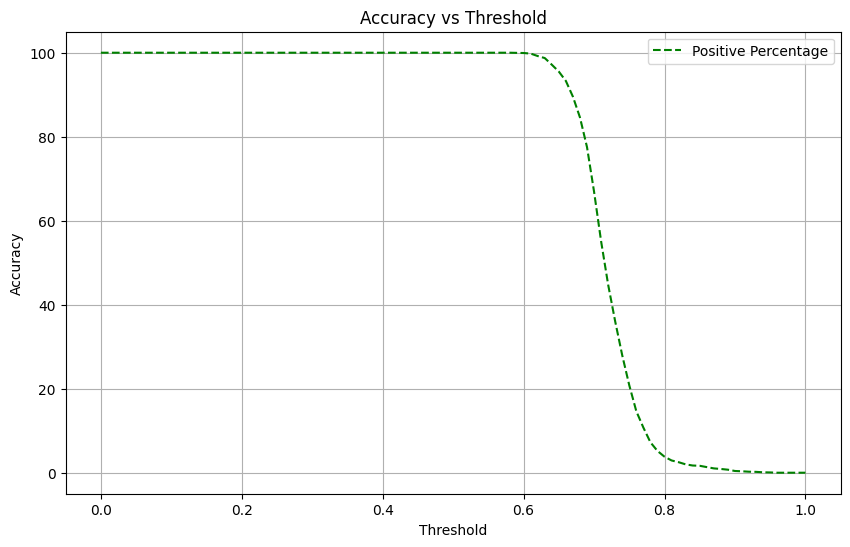

In [36]:
avg_similarities = np.array(avg_similarities)

thresholds = np.arange(0, 1.01, 0.01)

def calculate_metrics(avg_similarities, thresholds):
    accuracies = []
    positive_percentages = []
    for threshold in thresholds:
        predicted_positives = avg_similarities >= threshold
        accuracy = predicted_positives.mean()  # Accuracy is the proportion of predicted positives
        accuracies.append(accuracy)
        
        positive_percentage = (predicted_positives.sum() / len(predicted_positives)) * 100
        positive_percentages.append(positive_percentage)
    
    return positive_percentages

positive_percentages = calculate_metrics(avg_similarities, thresholds)

# Plot threshold vs accuracy and threshold vs positive percentage
plt.figure(figsize=(10, 6))
plt.plot(thresholds, positive_percentages, label='Positive Percentage', color='green', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

## Accuracy Based on a Threshold
Keeping the threshold as 0.7, we get our percent of positives

In [37]:
acc = (avg_similarities >= 0.7).mean() * 100

print("Accuracy based on threshold at 0.7 is: ", acc)

Accuracy based on threshold at 0.7 is:  66.90696876072776


## Human Testing Samples
Giving the model 3 songs, on the basis of which it gives us a recommendation for a song.

In [ ]:
def recommend_songs_based_on_three(song1_name, song2_name, song3_name, data, function_map, weights, top_n=1):
    song1 = data[data['Name'] == song1_name].iloc[0]
    song2 = data[data['Name'] == song2_name].iloc[0]
    song3 = data[data['Name'] == song3_name].iloc[0]
    
    def average_similarity(row):
        sim1 = compute_similarity(row, song1, function_map, weights)
        sim2 = compute_similarity(row, song2, function_map, weights)
        sim3 = compute_similarity(row, song3, function_map, weights)
        return (sim1 + sim2 + sim3) / 3
    
    data['Average Similarity'] = data.apply(average_similarity, axis=1)
    
    filtered_data = data[~data['Name'].isin([song1_name, song2_name, song3_name])]
    
    recommended_songs = filtered_data.sort_values(by='Average Similarity', ascending=False).head(top_n)
    
    return recommended_songs[['Name', 'Average Similarity']]

In [ ]:
recommended_song1 = recommend_songs_based_on_three("Silence" , "Roses" , "Animal", data, 
                                                   similarity_functions, numerical_weights)
print(recommended_song1)

In [ ]:
recommended_song2 = recommend_songs_based_on_three('Khalibali', 
                                                   'Main Aai Hoon Up Bihar Lootne', 
                                                   'Tinku Jiya', data, similarity_functions, 
                                                   numerical_weights)
print(recommended_song2)

In [ ]:
recommended_song3 = recommend_songs_based_on_three("Body", 
                                                   "There Is a Light That Never Goes Out - 2011 Remaster" ,
                                                   "Millennium", data, 
                                                   similarity_functions, numerical_weights)
print(recommended_song3)

In [ ]:
recommended_song4 = recommend_songs_based_on_three("Road to Nowhere" , 
                                                   "Bones" , 
                                                   "Stereo Hearts (feat. Adam Levine)", data, 
                                                   similarity_functions, numerical_weights)
print(recommended_song4)

In [ ]:
recommended_song5 = recommend_songs_based_on_three('Genie In a Bottle', 'Despacito', 
                                                   'Como Yo Le Doy - Spanglish Version', 
                                                   data, similarity_functions, numerical_weights)
print(recommended_song5)